In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import backend as K

2023-10-25 16:07:38.866107: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 16:07:39.864897: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
GUpSV_S = np.loadtxt('./datasets/dSHR_BBPF_GUp_150_160_SV_norm.npy')
GUpSV_U = np.loadtxt('./datasets/dSHR_BBPF_GUp_161_170_SV_norm.npy')
GUpLV_S = np.loadtxt('./datasets/dSHR_BBPF_GUp_150_160__norm.npy')
GUpLV_U = np.loadtxt('./datasets/dSHR_BBPF_GUp_161_170__norm.npy')

GUpSV_S_scale = np.loadtxt('./datasets/dSHR_BBPF_GUp_150_160_SV_scale.txt')
GUpSV_U_scale = np.loadtxt('./datasets/dSHR_BBPF_GUp_161_170_SV_scale.txt')
GUpLV_S_scale = np.loadtxt('./datasets/dSHR_BBPF_GUp_150_160__scale.txt')
GUpLV_U_scale = np.loadtxt('./datasets/dSHR_BBPF_GUp_161_170__scale.txt')

GUpSV_S_means = np.loadtxt('./datasets/dSHR_BBPF_GUp_150_160_SV_means.txt')
GUpSV_U_means = np.loadtxt('./datasets/dSHR_BBPF_GUp_161_170_SV_means.txt')
GUpLV_S_means = np.loadtxt('./datasets/dSHR_BBPF_GUp_150_160__means.txt')
GUpLV_U_means = np.loadtxt('./datasets/dSHR_BBPF_GUp_161_170__means.txt')

In [17]:
ni = 12 # GUp: 12, UUp: 9
no = 1  # GUp: 1 , UUp: 1
dt = GUpLV_S
sc = GUpLV_S_scale
mn = GUpLV_S_means

In [18]:
dt.shape

(4613741, 13)

In [19]:
dt_U = GUpLV_U
sc_U = GUpLV_U_scale
mn_U = GUpLV_U_means

In [6]:
np.random.shuffle(dt)

dt.shape

(4613741, 10)

In [7]:
split = int(0.8*dt.shape[0])
x_train = dt[0:split,0:-1]
y_train = dt[0:split,-1]

x_val = dt[split+1:-1,0:-1]
y_val = dt[split+1:-1,-1]

In [6]:
def coeff_determination(y_true, y_pred):
    SS_res = K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [21]:
def Model(nneurons, nfeat, nlab, nlayers):
    model = tf.keras.models.Sequential()
    input_layer = tf.keras.layers.Input(shape=(nfeat))

    x = tf.keras.layers.Dense(nneurons, activation='relu', use_bias=True)(input_layer)
    for i in range(1,nlayers):
        x = tf.keras.layers.Dense(nneurons, activation='relu', use_bias=True)(x)
        
    output_layer = tf.keras.layers.Dense(nlab, activation='linear', use_bias=True)(x)
        
    model = tf.keras.models.Model(input_layer, output_layer)
        
    adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, 
                                           beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[coeff_determination])
    model._name = f'model_n_{nneurons}_lay_{nlayers}'
    return model

In [22]:
neurons = 60 #[20, 40, 60]
layers = 5 #[2, 3, 5, 7]
model = Model(neurons, ni, no, layers)

checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath='ANN_checkpoints/ANN_M2_LV_weight-{epoch:02d}.h5', 
                                                  monitor='val_loss', 
                                                  verbose=1, 
                                                  save_best_only=True, 
                                                  mode='min')
model.summary()

Model: "model_n_60_lay_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_6 (Dense)             (None, 60)                780       
                                                                 
 dense_7 (Dense)             (None, 60)                3660      
                                                                 
 dense_8 (Dense)             (None, 60)                3660      
                                                                 
 dense_9 (Dense)             (None, 60)                3660      
                                                                 
 dense_10 (Dense)            (None, 60)                3660      
                                                                 
 dense_11 (Dense)            (None, 1)            

In [11]:
eps= 5000
bs = 4096
vlbs = int(bs / 4)
hist = model.fit(x_train, y_train, batch_size= bs, epochs= eps, 
                 validation_data=[x_val,y_val], validation_batch_size= vlbs, callbacks=[checkpoints])

Epoch 1/5000


2023-10-05 13:31:11.936358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-05 13:31:12.162138: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x2385a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-05 13:31:12.162157: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-10-05 13:31:12.271478: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-05 13:31:12.421433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-05 13:31:12.749651: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 13:31:12.884526: I ./

902/902 [==============================] - ETA: 0s - loss: 0.8501 - coeff_determination: 0.2078
Epoch 1: val_loss improved from inf to 0.78384, saving model to ANN_checkpoints/5_60_UUp_LV_weight-01.h5
902/902 [==============================] - 6s 4ms/step - loss: 0.8501 - coeff_determination: 0.2078 - val_loss: 0.7838 - val_coeff_determination: 0.3075
Epoch 2/5000
901/902 [============================>.] - ETA: 0s - loss: 0.7956 - coeff_determination: 0.2735
Epoch 2: val_loss improved from 0.78384 to 0.76034, saving model to ANN_checkpoints/5_60_UUp_LV_weight-02.h5
902/902 [==============================] - 3s 4ms/step - loss: 0.7955 - coeff_determination: 0.2739 - val_loss: 0.7603 - val_coeff_determination: 0.3128
Epoch 3/5000
902/902 [==============================] - ETA: 0s - loss: 0.7706 - coeff_determination: 0.3065
Epoch 3: val_loss did not improve from 0.76034
902/902 [==============================] - 3s 3ms/step - loss: 0.7706 - coeff_determination: 0.3065 - val_loss: 0.7829 

902/902 [==============================] - ETA: 0s - loss: 0.6314 - coeff_determination: 0.4401
Epoch 50: val_loss did not improve from 0.60279
902/902 [==============================] - 3s 3ms/step - loss: 0.6314 - coeff_determination: 0.4401 - val_loss: 0.6035 - val_coeff_determination: 0.4554
Epoch 51/5000
899/902 [============================>.] - ETA: 0s - loss: 0.6483 - coeff_determination: 0.4411
Epoch 51: val_loss did not improve from 0.60279
902/902 [==============================] - 3s 3ms/step - loss: 0.6473 - coeff_determination: 0.4416 - val_loss: 0.6437 - val_coeff_determination: 0.4100
Epoch 52/5000
902/902 [==============================] - ETA: 0s - loss: 0.6356 - coeff_determination: 0.4455
Epoch 52: val_loss did not improve from 0.60279
902/902 [==============================] - 3s 3ms/step - loss: 0.6356 - coeff_determination: 0.4455 - val_loss: 0.6338 - val_coeff_determination: 0.4231
Epoch 53/5000
900/902 [============================>.] - ETA: 0s - loss: 0.6295 -

Epoch 76/5000
902/902 [==============================] - ETA: 0s - loss: 0.6111 - coeff_determination: 0.4582
Epoch 76: val_loss did not improve from 0.56794
902/902 [==============================] - 3s 3ms/step - loss: 0.6111 - coeff_determination: 0.4582 - val_loss: 0.5908 - val_coeff_determination: 0.3925
Epoch 77/5000
902/902 [==============================] - ETA: 0s - loss: 0.6225 - coeff_determination: 0.4435
Epoch 77: val_loss did not improve from 0.56794
902/902 [==============================] - 3s 3ms/step - loss: 0.6225 - coeff_determination: 0.4435 - val_loss: 0.6220 - val_coeff_determination: 0.2651
Epoch 78/5000
901/902 [============================>.] - ETA: 0s - loss: 0.6104 - coeff_determination: 0.4551
Epoch 78: val_loss did not improve from 0.56794
902/902 [==============================] - 3s 3ms/step - loss: 0.6104 - coeff_determination: 0.4547 - val_loss: 0.6347 - val_coeff_determination: 0.3661
Epoch 79/5000
902/902 [==============================] - ETA: 0s - 

902/902 [==============================] - ETA: 0s - loss: 0.5583 - coeff_determination: 0.4689
Epoch 128: val_loss did not improve from 0.52498
902/902 [==============================] - 3s 3ms/step - loss: 0.5583 - coeff_determination: 0.4689 - val_loss: 0.5395 - val_coeff_determination: 0.4013
Epoch 129/5000
899/902 [============================>.] - ETA: 0s - loss: 0.5589 - coeff_determination: 0.4801
Epoch 129: val_loss did not improve from 0.52498
902/902 [==============================] - 3s 3ms/step - loss: 0.5589 - coeff_determination: 0.4804 - val_loss: 0.5854 - val_coeff_determination: 0.2105
Epoch 130/5000
902/902 [==============================] - ETA: 0s - loss: 0.5671 - coeff_determination: 0.4817
Epoch 130: val_loss did not improve from 0.52498
902/902 [==============================] - 3s 3ms/step - loss: 0.5671 - coeff_determination: 0.4817 - val_loss: 0.5470 - val_coeff_determination: 0.3143
Epoch 131/5000
902/902 [==============================] - ETA: 0s - loss: 0.

Epoch 154/5000
897/902 [============================>.] - ETA: 0s - loss: 0.5392 - coeff_determination: 0.4975
Epoch 154: val_loss did not improve from 0.50850
902/902 [==============================] - 3s 3ms/step - loss: 0.5378 - coeff_determination: 0.4982 - val_loss: 0.5597 - val_coeff_determination: 0.4436
Epoch 155/5000
902/902 [==============================] - ETA: 0s - loss: 0.5473 - coeff_determination: 0.4986
Epoch 155: val_loss did not improve from 0.50850
902/902 [==============================] - 3s 3ms/step - loss: 0.5473 - coeff_determination: 0.4986 - val_loss: 0.5457 - val_coeff_determination: 0.3904
Epoch 156/5000
902/902 [==============================] - ETA: 0s - loss: 0.5321 - coeff_determination: 0.5024
Epoch 156: val_loss did not improve from 0.50850
902/902 [==============================] - 3s 3ms/step - loss: 0.5321 - coeff_determination: 0.5024 - val_loss: 0.6021 - val_coeff_determination: 0.1728
Epoch 157/5000
902/902 [==============================] - ETA

Epoch 180/5000
902/902 [==============================] - ETA: 0s - loss: 0.5506 - coeff_determination: 0.5083
Epoch 180: val_loss did not improve from 0.49494
902/902 [==============================] - 3s 3ms/step - loss: 0.5506 - coeff_determination: 0.5083 - val_loss: 0.5646 - val_coeff_determination: 0.3504
Epoch 181/5000
902/902 [==============================] - ETA: 0s - loss: 0.5373 - coeff_determination: 0.5003
Epoch 181: val_loss did not improve from 0.49494
902/902 [==============================] - 3s 3ms/step - loss: 0.5373 - coeff_determination: 0.5003 - val_loss: 0.6166 - val_coeff_determination: 0.3004
Epoch 182/5000
902/902 [==============================] - ETA: 0s - loss: 0.5464 - coeff_determination: 0.5071
Epoch 182: val_loss did not improve from 0.49494
902/902 [==============================] - 3s 3ms/step - loss: 0.5464 - coeff_determination: 0.5071 - val_loss: 0.6286 - val_coeff_determination: 0.4001
Epoch 183/5000
902/902 [==============================] - ETA

Epoch 206/5000
902/902 [==============================] - ETA: 0s - loss: 0.5464 - coeff_determination: 0.4905
Epoch 206: val_loss did not improve from 0.49333
902/902 [==============================] - 3s 3ms/step - loss: 0.5464 - coeff_determination: 0.4905 - val_loss: 0.5565 - val_coeff_determination: 0.3320
Epoch 207/5000
902/902 [==============================] - ETA: 0s - loss: 0.5162 - coeff_determination: 0.5078
Epoch 207: val_loss did not improve from 0.49333
902/902 [==============================] - 3s 3ms/step - loss: 0.5162 - coeff_determination: 0.5078 - val_loss: 0.5652 - val_coeff_determination: 0.3091
Epoch 208/5000
902/902 [==============================] - ETA: 0s - loss: 0.5130 - coeff_determination: 0.5336
Epoch 208: val_loss did not improve from 0.49333
902/902 [==============================] - 3s 3ms/step - loss: 0.5130 - coeff_determination: 0.5336 - val_loss: 0.5977 - val_coeff_determination: 0.4450
Epoch 209/5000
894/902 [============================>.] - ETA

Epoch 232/5000
901/902 [============================>.] - ETA: 0s - loss: 0.5212 - coeff_determination: 0.5235
Epoch 232: val_loss did not improve from 0.49015
902/902 [==============================] - 3s 3ms/step - loss: 0.5211 - coeff_determination: 0.5237 - val_loss: 0.7854 - val_coeff_determination: -0.1072
Epoch 233/5000
902/902 [==============================] - ETA: 0s - loss: 0.5463 - coeff_determination: 0.5197
Epoch 233: val_loss improved from 0.49015 to 0.48736, saving model to ANN_checkpoints/5_60_UUp_LV_weight-233.h5
902/902 [==============================] - 4s 5ms/step - loss: 0.5463 - coeff_determination: 0.5197 - val_loss: 0.4874 - val_coeff_determination: 0.3744
Epoch 234/5000
902/902 [==============================] - ETA: 0s - loss: 0.4980 - coeff_determination: 0.5376
Epoch 234: val_loss did not improve from 0.48736
902/902 [==============================] - 3s 3ms/step - loss: 0.4980 - coeff_determination: 0.5376 - val_loss: 0.5693 - val_coeff_determination: 0.36

Epoch 258/5000
897/902 [============================>.] - ETA: 0s - loss: 0.5017 - coeff_determination: 0.5368
Epoch 258: val_loss did not improve from 0.48177
902/902 [==============================] - 3s 3ms/step - loss: 0.5009 - coeff_determination: 0.5341 - val_loss: 0.5819 - val_coeff_determination: 0.3869
Epoch 259/5000
902/902 [==============================] - ETA: 0s - loss: 0.5018 - coeff_determination: 0.5297
Epoch 259: val_loss did not improve from 0.48177
902/902 [==============================] - 3s 3ms/step - loss: 0.5018 - coeff_determination: 0.5297 - val_loss: 0.5040 - val_coeff_determination: 0.3898
Epoch 260/5000
902/902 [==============================] - ETA: 0s - loss: 0.4927 - coeff_determination: 0.5348
Epoch 260: val_loss did not improve from 0.48177
902/902 [==============================] - 3s 3ms/step - loss: 0.4927 - coeff_determination: 0.5348 - val_loss: 0.5838 - val_coeff_determination: 0.4371
Epoch 261/5000
902/902 [==============================] - ETA

Epoch 310/5000
902/902 [==============================] - ETA: 0s - loss: 0.4777 - coeff_determination: 0.5396
Epoch 310: val_loss did not improve from 0.47084
902/902 [==============================] - 3s 3ms/step - loss: 0.4777 - coeff_determination: 0.5396 - val_loss: 0.6753 - val_coeff_determination: 0.2753
Epoch 311/5000
902/902 [==============================] - ETA: 0s - loss: 0.5117 - coeff_determination: 0.5295
Epoch 311: val_loss did not improve from 0.47084
902/902 [==============================] - 3s 3ms/step - loss: 0.5117 - coeff_determination: 0.5295 - val_loss: 0.5595 - val_coeff_determination: 0.4095
Epoch 312/5000
902/902 [==============================] - ETA: 0s - loss: 0.4843 - coeff_determination: 0.5426
Epoch 312: val_loss did not improve from 0.47084
902/902 [==============================] - 3s 3ms/step - loss: 0.4843 - coeff_determination: 0.5426 - val_loss: 0.6096 - val_coeff_determination: 0.3727
Epoch 313/5000
898/902 [============================>.] - ETA

Epoch 336/5000
902/902 [==============================] - ETA: 0s - loss: 0.5042 - coeff_determination: 0.5326
Epoch 336: val_loss did not improve from 0.46309
902/902 [==============================] - 3s 3ms/step - loss: 0.5042 - coeff_determination: 0.5326 - val_loss: 0.6213 - val_coeff_determination: 0.4180
Epoch 337/5000
902/902 [==============================] - ETA: 0s - loss: 0.5459 - coeff_determination: 0.5316
Epoch 337: val_loss did not improve from 0.46309
902/902 [==============================] - 3s 3ms/step - loss: 0.5459 - coeff_determination: 0.5316 - val_loss: 0.6496 - val_coeff_determination: 0.4146
Epoch 338/5000
898/902 [============================>.] - ETA: 0s - loss: 0.4935 - coeff_determination: 0.5399
Epoch 338: val_loss did not improve from 0.46309
902/902 [==============================] - 3s 3ms/step - loss: 0.4937 - coeff_determination: 0.5374 - val_loss: 0.4882 - val_coeff_determination: 0.2233
Epoch 339/5000
902/902 [==============================] - ETA

Epoch 388/5000
902/902 [==============================] - ETA: 0s - loss: 0.4926 - coeff_determination: 0.5367
Epoch 388: val_loss did not improve from 0.44993
902/902 [==============================] - 3s 3ms/step - loss: 0.4926 - coeff_determination: 0.5367 - val_loss: 0.5963 - val_coeff_determination: 0.2785
Epoch 389/5000
902/902 [==============================] - ETA: 0s - loss: 0.4792 - coeff_determination: 0.5519
Epoch 389: val_loss did not improve from 0.44993
902/902 [==============================] - 3s 3ms/step - loss: 0.4792 - coeff_determination: 0.5519 - val_loss: 0.5801 - val_coeff_determination: 0.3492
Epoch 390/5000
902/902 [==============================] - ETA: 0s - loss: 0.4819 - coeff_determination: 0.5524
Epoch 390: val_loss did not improve from 0.44993
902/902 [==============================] - 3s 3ms/step - loss: 0.4819 - coeff_determination: 0.5524 - val_loss: 0.6065 - val_coeff_determination: 0.3821
Epoch 391/5000
902/902 [==============================] - ETA

Epoch 414/5000
900/902 [============================>.] - ETA: 0s - loss: 0.4828 - coeff_determination: 0.5237
Epoch 414: val_loss did not improve from 0.44386
902/902 [==============================] - 3s 3ms/step - loss: 0.4829 - coeff_determination: 0.5236 - val_loss: 0.5872 - val_coeff_determination: 0.4509
Epoch 415/5000
902/902 [==============================] - ETA: 0s - loss: 0.5017 - coeff_determination: 0.5322
Epoch 415: val_loss did not improve from 0.44386
902/902 [==============================] - 3s 3ms/step - loss: 0.5017 - coeff_determination: 0.5322 - val_loss: 0.5089 - val_coeff_determination: 0.2926
Epoch 416/5000
902/902 [==============================] - ETA: 0s - loss: 0.4907 - coeff_determination: 0.5529
Epoch 416: val_loss did not improve from 0.44386
902/902 [==============================] - 3s 3ms/step - loss: 0.4907 - coeff_determination: 0.5529 - val_loss: 0.4816 - val_coeff_determination: 0.4670
Epoch 417/5000
902/902 [==============================] - ETA

Epoch 440/5000
902/902 [==============================] - ETA: 0s - loss: 0.4572 - coeff_determination: 0.5593
Epoch 440: val_loss did not improve from 0.44238
902/902 [==============================] - 3s 3ms/step - loss: 0.4572 - coeff_determination: 0.5593 - val_loss: 0.4451 - val_coeff_determination: 0.4350
Epoch 441/5000
902/902 [==============================] - ETA: 0s - loss: 0.4683 - coeff_determination: 0.5333
Epoch 441: val_loss did not improve from 0.44238
902/902 [==============================] - 3s 3ms/step - loss: 0.4683 - coeff_determination: 0.5333 - val_loss: 0.5089 - val_coeff_determination: 0.3970
Epoch 442/5000
902/902 [==============================] - ETA: 0s - loss: 0.4686 - coeff_determination: 0.5532
Epoch 442: val_loss did not improve from 0.44238
902/902 [==============================] - 3s 3ms/step - loss: 0.4686 - coeff_determination: 0.5532 - val_loss: 0.6137 - val_coeff_determination: 0.4390
Epoch 443/5000
902/902 [==============================] - ETA

902/902 [==============================] - ETA: 0s - loss: 0.4472 - coeff_determination: 0.5697
Epoch 492: val_loss did not improve from 0.44238
902/902 [==============================] - 3s 3ms/step - loss: 0.4472 - coeff_determination: 0.5697 - val_loss: 0.4632 - val_coeff_determination: 0.2943
Epoch 493/5000
902/902 [==============================] - ETA: 0s - loss: 0.4759 - coeff_determination: 0.5485
Epoch 493: val_loss did not improve from 0.44238
902/902 [==============================] - 3s 3ms/step - loss: 0.4759 - coeff_determination: 0.5485 - val_loss: 0.5170 - val_coeff_determination: 0.2769
Epoch 494/5000
901/902 [============================>.] - ETA: 0s - loss: 0.4531 - coeff_determination: 0.5546
Epoch 494: val_loss did not improve from 0.44238
902/902 [==============================] - 3s 3ms/step - loss: 0.4530 - coeff_determination: 0.5546 - val_loss: 0.4528 - val_coeff_determination: 0.4501
Epoch 495/5000
902/902 [==============================] - ETA: 0s - loss: 0.

902/902 [==============================] - ETA: 0s - loss: 0.4839 - coeff_determination: 0.5416
Epoch 518: val_loss did not improve from 0.43726
902/902 [==============================] - 3s 3ms/step - loss: 0.4839 - coeff_determination: 0.5416 - val_loss: 0.4783 - val_coeff_determination: 0.4234
Epoch 519/5000
902/902 [==============================] - ETA: 0s - loss: 0.4544 - coeff_determination: 0.5597
Epoch 519: val_loss did not improve from 0.43726
902/902 [==============================] - 3s 3ms/step - loss: 0.4544 - coeff_determination: 0.5597 - val_loss: 0.5315 - val_coeff_determination: 0.4240
Epoch 520/5000
902/902 [==============================] - ETA: 0s - loss: 0.4708 - coeff_determination: 0.5657
Epoch 520: val_loss did not improve from 0.43726
902/902 [==============================] - 3s 3ms/step - loss: 0.4708 - coeff_determination: 0.5657 - val_loss: 0.5862 - val_coeff_determination: 0.4014
Epoch 521/5000
902/902 [==============================] - ETA: 0s - loss: 0.

898/902 [============================>.] - ETA: 0s - loss: 0.4808 - coeff_determination: 0.5780
Epoch 570: val_loss did not improve from 0.43726
902/902 [==============================] - 3s 3ms/step - loss: 0.4819 - coeff_determination: 0.5779 - val_loss: 0.4875 - val_coeff_determination: 0.4075
Epoch 571/5000
902/902 [==============================] - ETA: 0s - loss: 0.4589 - coeff_determination: 0.5564
Epoch 571: val_loss did not improve from 0.43726
902/902 [==============================] - 3s 3ms/step - loss: 0.4589 - coeff_determination: 0.5564 - val_loss: 0.4706 - val_coeff_determination: 0.4522
Epoch 572/5000
902/902 [==============================] - ETA: 0s - loss: 0.4813 - coeff_determination: 0.5573
Epoch 572: val_loss did not improve from 0.43726
902/902 [==============================] - 3s 3ms/step - loss: 0.4813 - coeff_determination: 0.5573 - val_loss: 0.6371 - val_coeff_determination: 0.3131
Epoch 573/5000
902/902 [==============================] - ETA: 0s - loss: 0.

902/902 [==============================] - ETA: 0s - loss: 0.4521 - coeff_determination: 0.5691
Epoch 622: val_loss did not improve from 0.43726
902/902 [==============================] - 3s 3ms/step - loss: 0.4521 - coeff_determination: 0.5691 - val_loss: 0.4734 - val_coeff_determination: 0.3087
Epoch 623/5000
902/902 [==============================] - ETA: 0s - loss: 0.4519 - coeff_determination: 0.5593
Epoch 623: val_loss did not improve from 0.43726
902/902 [==============================] - 3s 3ms/step - loss: 0.4519 - coeff_determination: 0.5593 - val_loss: 0.4885 - val_coeff_determination: 0.1911
Epoch 624/5000
902/902 [==============================] - ETA: 0s - loss: 0.4369 - coeff_determination: 0.5728
Epoch 624: val_loss did not improve from 0.43726
902/902 [==============================] - 3s 3ms/step - loss: 0.4369 - coeff_determination: 0.5728 - val_loss: 0.4665 - val_coeff_determination: 0.3523
Epoch 625/5000
902/902 [==============================] - ETA: 0s - loss: 0.

902/902 [==============================] - ETA: 0s - loss: 0.4562 - coeff_determination: 0.5603
Epoch 674: val_loss did not improve from 0.43726
902/902 [==============================] - 3s 3ms/step - loss: 0.4562 - coeff_determination: 0.5603 - val_loss: 0.4801 - val_coeff_determination: 0.4227
Epoch 675/5000
902/902 [==============================] - ETA: 0s - loss: 0.4480 - coeff_determination: 0.5822
Epoch 675: val_loss did not improve from 0.43726
902/902 [==============================] - 3s 3ms/step - loss: 0.4480 - coeff_determination: 0.5822 - val_loss: 0.4762 - val_coeff_determination: 0.3284
Epoch 676/5000
902/902 [==============================] - ETA: 0s - loss: 0.4247 - coeff_determination: 0.5704
Epoch 676: val_loss did not improve from 0.43726
902/902 [==============================] - 3s 3ms/step - loss: 0.4247 - coeff_determination: 0.5704 - val_loss: 0.4598 - val_coeff_determination: 0.4021
Epoch 677/5000
902/902 [==============================] - ETA: 0s - loss: 0.

902/902 [==============================] - ETA: 0s - loss: 0.4777 - coeff_determination: 0.5289
Epoch 726: val_loss did not improve from 0.43726
902/902 [==============================] - 3s 3ms/step - loss: 0.4777 - coeff_determination: 0.5289 - val_loss: 0.5169 - val_coeff_determination: 0.3748
Epoch 727/5000
898/902 [============================>.] - ETA: 0s - loss: 0.4470 - coeff_determination: 0.5767
Epoch 727: val_loss did not improve from 0.43726
902/902 [==============================] - 3s 3ms/step - loss: 0.4466 - coeff_determination: 0.5754 - val_loss: 0.4383 - val_coeff_determination: 0.3610
Epoch 728/5000
902/902 [==============================] - ETA: 0s - loss: 0.4391 - coeff_determination: 0.5638
Epoch 728: val_loss did not improve from 0.43726
902/902 [==============================] - 3s 3ms/step - loss: 0.4391 - coeff_determination: 0.5638 - val_loss: 0.4834 - val_coeff_determination: 0.3796
Epoch 729/5000
902/902 [==============================] - ETA: 0s - loss: 0.

Epoch 778/5000
902/902 [==============================] - ETA: 0s - loss: 0.4323 - coeff_determination: 0.5594
Epoch 778: val_loss did not improve from 0.41997
902/902 [==============================] - 3s 3ms/step - loss: 0.4323 - coeff_determination: 0.5594 - val_loss: 0.4409 - val_coeff_determination: 0.4243
Epoch 779/5000
902/902 [==============================] - ETA: 0s - loss: 0.5134 - coeff_determination: 0.5662
Epoch 779: val_loss did not improve from 0.41997
902/902 [==============================] - 3s 3ms/step - loss: 0.5134 - coeff_determination: 0.5662 - val_loss: 0.6166 - val_coeff_determination: 0.4522
Epoch 780/5000
902/902 [==============================] - ETA: 0s - loss: 0.5187 - coeff_determination: 0.5785
Epoch 780: val_loss did not improve from 0.41997
902/902 [==============================] - 3s 3ms/step - loss: 0.5187 - coeff_determination: 0.5785 - val_loss: 0.5506 - val_coeff_determination: 0.3254
Epoch 781/5000
902/902 [==============================] - ETA

902/902 [==============================] - ETA: 0s - loss: 0.4628 - coeff_determination: 0.5889
Epoch 830: val_loss improved from 0.41997 to 0.41848, saving model to ANN_checkpoints/5_60_UUp_LV_weight-830.h5
902/902 [==============================] - 3s 4ms/step - loss: 0.4628 - coeff_determination: 0.5889 - val_loss: 0.4185 - val_coeff_determination: 0.4494
Epoch 831/5000
902/902 [==============================] - ETA: 0s - loss: 0.4235 - coeff_determination: 0.5792
Epoch 831: val_loss did not improve from 0.41848
902/902 [==============================] - 3s 3ms/step - loss: 0.4235 - coeff_determination: 0.5792 - val_loss: 0.6204 - val_coeff_determination: 0.2950
Epoch 832/5000
902/902 [==============================] - ETA: 0s - loss: 0.4212 - coeff_determination: 0.5833
Epoch 832: val_loss did not improve from 0.41848
902/902 [==============================] - 3s 3ms/step - loss: 0.4212 - coeff_determination: 0.5833 - val_loss: 0.6167 - val_coeff_determination: 0.4056
Epoch 833/500

902/902 [==============================] - ETA: 0s - loss: 0.4242 - coeff_determination: 0.5799
Epoch 856: val_loss did not improve from 0.41848
902/902 [==============================] - 3s 3ms/step - loss: 0.4242 - coeff_determination: 0.5799 - val_loss: 0.6289 - val_coeff_determination: 0.4046
Epoch 857/5000
902/902 [==============================] - ETA: 0s - loss: 0.4647 - coeff_determination: 0.5722
Epoch 857: val_loss did not improve from 0.41848
902/902 [==============================] - 3s 3ms/step - loss: 0.4647 - coeff_determination: 0.5722 - val_loss: 0.5289 - val_coeff_determination: 0.2484
Epoch 858/5000
902/902 [==============================] - ETA: 0s - loss: 0.4129 - coeff_determination: 0.5897
Epoch 858: val_loss did not improve from 0.41848
902/902 [==============================] - 3s 3ms/step - loss: 0.4129 - coeff_determination: 0.5897 - val_loss: 0.5320 - val_coeff_determination: 0.3848
Epoch 859/5000
902/902 [==============================] - ETA: 0s - loss: 0.

902/902 [==============================] - ETA: 0s - loss: 0.4495 - coeff_determination: 0.5714
Epoch 882: val_loss did not improve from 0.41810
902/902 [==============================] - 3s 3ms/step - loss: 0.4495 - coeff_determination: 0.5714 - val_loss: 0.5000 - val_coeff_determination: 0.3260
Epoch 883/5000
902/902 [==============================] - ETA: 0s - loss: 0.4135 - coeff_determination: 0.5850
Epoch 883: val_loss did not improve from 0.41810
902/902 [==============================] - 3s 3ms/step - loss: 0.4135 - coeff_determination: 0.5850 - val_loss: 0.4699 - val_coeff_determination: 0.1540
Epoch 884/5000
902/902 [==============================] - ETA: 0s - loss: 0.4467 - coeff_determination: 0.5677
Epoch 884: val_loss did not improve from 0.41810
902/902 [==============================] - 3s 3ms/step - loss: 0.4467 - coeff_determination: 0.5677 - val_loss: 0.5453 - val_coeff_determination: 0.2873
Epoch 885/5000
902/902 [==============================] - ETA: 0s - loss: 0.

902/902 [==============================] - ETA: 0s - loss: 0.4551 - coeff_determination: 0.5518
Epoch 934: val_loss did not improve from 0.41810
902/902 [==============================] - 3s 3ms/step - loss: 0.4551 - coeff_determination: 0.5518 - val_loss: 0.6482 - val_coeff_determination: 0.3244
Epoch 935/5000
902/902 [==============================] - ETA: 0s - loss: 0.4414 - coeff_determination: 0.5860
Epoch 935: val_loss did not improve from 0.41810
902/902 [==============================] - 3s 3ms/step - loss: 0.4414 - coeff_determination: 0.5860 - val_loss: 0.4592 - val_coeff_determination: 0.4163
Epoch 936/5000
902/902 [==============================] - ETA: 0s - loss: 0.4775 - coeff_determination: 0.5905
Epoch 936: val_loss did not improve from 0.41810
902/902 [==============================] - 3s 3ms/step - loss: 0.4775 - coeff_determination: 0.5905 - val_loss: 0.4699 - val_coeff_determination: 0.4254
Epoch 937/5000
902/902 [==============================] - ETA: 0s - loss: 0.

902/902 [==============================] - ETA: 0s - loss: 0.4282 - coeff_determination: 0.6017
Epoch 986: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.4282 - coeff_determination: 0.6017 - val_loss: 0.5461 - val_coeff_determination: 0.4006
Epoch 987/5000
902/902 [==============================] - ETA: 0s - loss: 0.4659 - coeff_determination: 0.5862
Epoch 987: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.4659 - coeff_determination: 0.5862 - val_loss: 0.4902 - val_coeff_determination: 0.3156
Epoch 988/5000
902/902 [==============================] - ETA: 0s - loss: 0.4383 - coeff_determination: 0.5761
Epoch 988: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.4383 - coeff_determination: 0.5761 - val_loss: 0.4501 - val_coeff_determination: 0.2008
Epoch 989/5000
902/902 [==============================] - ETA: 0s - loss: 0.

902/902 [==============================] - ETA: 0s - loss: 0.4132 - coeff_determination: 0.5916
Epoch 1038: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.4132 - coeff_determination: 0.5916 - val_loss: 0.4514 - val_coeff_determination: 0.4039
Epoch 1039/5000
902/902 [==============================] - ETA: 0s - loss: 0.4124 - coeff_determination: 0.5891
Epoch 1039: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.4124 - coeff_determination: 0.5891 - val_loss: 0.4606 - val_coeff_determination: 0.3413
Epoch 1040/5000
902/902 [==============================] - ETA: 0s - loss: 0.4286 - coeff_determination: 0.5798
Epoch 1040: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.4286 - coeff_determination: 0.5798 - val_loss: 0.4665 - val_coeff_determination: 0.4197
Epoch 1041/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.4068 - coeff_determination: 0.6140
Epoch 1090: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.4068 - coeff_determination: 0.6140 - val_loss: 0.6510 - val_coeff_determination: 0.0575
Epoch 1091/5000
902/902 [==============================] - ETA: 0s - loss: 0.4648 - coeff_determination: 0.5756
Epoch 1091: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.4648 - coeff_determination: 0.5756 - val_loss: 0.5429 - val_coeff_determination: 0.4126
Epoch 1092/5000
902/902 [==============================] - ETA: 0s - loss: 0.4175 - coeff_determination: 0.6022
Epoch 1092: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.4175 - coeff_determination: 0.6022 - val_loss: 0.4423 - val_coeff_determination: 0.3865
Epoch 1093/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.4047 - coeff_determination: 0.5958
Epoch 1142: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.4047 - coeff_determination: 0.5958 - val_loss: 0.4621 - val_coeff_determination: 0.2967
Epoch 1143/5000
902/902 [==============================] - ETA: 0s - loss: 0.4122 - coeff_determination: 0.5930
Epoch 1143: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.4122 - coeff_determination: 0.5930 - val_loss: 0.4407 - val_coeff_determination: 0.3232
Epoch 1144/5000
902/902 [==============================] - ETA: 0s - loss: 0.4241 - coeff_determination: 0.5946
Epoch 1144: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.4241 - coeff_determination: 0.5946 - val_loss: 0.4519 - val_coeff_determination: 0.2465
Epoch 1145/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3922 - coeff_determination: 0.6140
Epoch 1194: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.3922 - coeff_determination: 0.6140 - val_loss: 0.4637 - val_coeff_determination: 0.3392
Epoch 1195/5000
902/902 [==============================] - ETA: 0s - loss: 0.3936 - coeff_determination: 0.6011
Epoch 1195: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.3936 - coeff_determination: 0.6011 - val_loss: 0.4407 - val_coeff_determination: 0.4472
Epoch 1196/5000
902/902 [==============================] - ETA: 0s - loss: 0.4135 - coeff_determination: 0.5867
Epoch 1196: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.4135 - coeff_determination: 0.5867 - val_loss: 0.4936 - val_coeff_determination: 0.3878
Epoch 1197/5000
899/902 [============================>.] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3942 - coeff_determination: 0.5855
Epoch 1246: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.3942 - coeff_determination: 0.5855 - val_loss: 0.4939 - val_coeff_determination: 0.4026
Epoch 1247/5000
902/902 [==============================] - ETA: 0s - loss: 0.4054 - coeff_determination: 0.5849
Epoch 1247: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.4054 - coeff_determination: 0.5849 - val_loss: 0.4453 - val_coeff_determination: 0.3491
Epoch 1248/5000
902/902 [==============================] - ETA: 0s - loss: 0.3913 - coeff_determination: 0.5923
Epoch 1248: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.3913 - coeff_determination: 0.5923 - val_loss: 0.4512 - val_coeff_determination: 0.3522
Epoch 1249/5000
902/902 [==============================] - ETA: 0s - lo

900/902 [============================>.] - ETA: 0s - loss: 0.4115 - coeff_determination: 0.5732
Epoch 1298: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.4113 - coeff_determination: 0.5737 - val_loss: 0.4386 - val_coeff_determination: 0.3834
Epoch 1299/5000
902/902 [==============================] - ETA: 0s - loss: 0.3820 - coeff_determination: 0.6148
Epoch 1299: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.3820 - coeff_determination: 0.6148 - val_loss: 0.4510 - val_coeff_determination: 0.3600
Epoch 1300/5000
902/902 [==============================] - ETA: 0s - loss: 0.3938 - coeff_determination: 0.5993
Epoch 1300: val_loss did not improve from 0.41279
902/902 [==============================] - 3s 3ms/step - loss: 0.3938 - coeff_determination: 0.5993 - val_loss: 0.4642 - val_coeff_determination: 0.3644
Epoch 1301/5000
902/902 [==============================] - ETA: 0s - lo

Epoch 1350/5000
902/902 [==============================] - ETA: 0s - loss: 0.4168 - coeff_determination: 0.5909
Epoch 1350: val_loss did not improve from 0.41182
902/902 [==============================] - 3s 3ms/step - loss: 0.4168 - coeff_determination: 0.5909 - val_loss: 0.6284 - val_coeff_determination: 0.0738
Epoch 1351/5000
902/902 [==============================] - ETA: 0s - loss: 0.4278 - coeff_determination: 0.5896
Epoch 1351: val_loss did not improve from 0.41182
902/902 [==============================] - 3s 3ms/step - loss: 0.4278 - coeff_determination: 0.5896 - val_loss: 0.4814 - val_coeff_determination: 0.2522
Epoch 1352/5000
902/902 [==============================] - ETA: 0s - loss: 0.4219 - coeff_determination: 0.5892
Epoch 1352: val_loss did not improve from 0.41182
902/902 [==============================] - 3s 3ms/step - loss: 0.4219 - coeff_determination: 0.5892 - val_loss: 0.4912 - val_coeff_determination: 0.3828
Epoch 1353/5000
900/902 [============================>.

902/902 [==============================] - ETA: 0s - loss: 0.4153 - coeff_determination: 0.5836
Epoch 1376: val_loss did not improve from 0.41182
902/902 [==============================] - 3s 3ms/step - loss: 0.4153 - coeff_determination: 0.5836 - val_loss: 0.5785 - val_coeff_determination: 0.4174
Epoch 1377/5000
902/902 [==============================] - ETA: 0s - loss: 0.4144 - coeff_determination: 0.5929
Epoch 1377: val_loss did not improve from 0.41182
902/902 [==============================] - 3s 3ms/step - loss: 0.4144 - coeff_determination: 0.5929 - val_loss: 0.4642 - val_coeff_determination: 0.2657
Epoch 1378/5000
900/902 [============================>.] - ETA: 0s - loss: 0.4199 - coeff_determination: 0.6050
Epoch 1378: val_loss did not improve from 0.41182
902/902 [==============================] - 3s 3ms/step - loss: 0.4196 - coeff_determination: 0.6056 - val_loss: 0.4505 - val_coeff_determination: 0.3843
Epoch 1379/5000
902/902 [==============================] - ETA: 0s - lo

900/902 [============================>.] - ETA: 0s - loss: 0.4074 - coeff_determination: 0.5966
Epoch 1428: val_loss did not improve from 0.41182
902/902 [==============================] - 3s 3ms/step - loss: 0.4077 - coeff_determination: 0.5965 - val_loss: 0.4462 - val_coeff_determination: 0.3165
Epoch 1429/5000
902/902 [==============================] - ETA: 0s - loss: 0.3901 - coeff_determination: 0.6157
Epoch 1429: val_loss did not improve from 0.41182
902/902 [==============================] - 3s 3ms/step - loss: 0.3901 - coeff_determination: 0.6157 - val_loss: 0.4330 - val_coeff_determination: 0.4153
Epoch 1430/5000
902/902 [==============================] - ETA: 0s - loss: 0.3972 - coeff_determination: 0.5813
Epoch 1430: val_loss did not improve from 0.41182
902/902 [==============================] - 3s 3ms/step - loss: 0.3972 - coeff_determination: 0.5813 - val_loss: 0.5023 - val_coeff_determination: 0.4014
Epoch 1431/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.4185 - coeff_determination: 0.5921
Epoch 1480: val_loss did not improve from 0.41182
902/902 [==============================] - 3s 3ms/step - loss: 0.4185 - coeff_determination: 0.5921 - val_loss: 0.4814 - val_coeff_determination: 0.3484
Epoch 1481/5000
902/902 [==============================] - ETA: 0s - loss: 0.3981 - coeff_determination: 0.6086
Epoch 1481: val_loss did not improve from 0.41182
902/902 [==============================] - 3s 3ms/step - loss: 0.3981 - coeff_determination: 0.6086 - val_loss: 0.4820 - val_coeff_determination: 0.2615
Epoch 1482/5000
902/902 [==============================] - ETA: 0s - loss: 0.3958 - coeff_determination: 0.6017
Epoch 1482: val_loss did not improve from 0.41182
902/902 [==============================] - 3s 3ms/step - loss: 0.3958 - coeff_determination: 0.6017 - val_loss: 0.4700 - val_coeff_determination: 0.3260
Epoch 1483/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.4036 - coeff_determination: 0.5987
Epoch 1532: val_loss did not improve from 0.41182
902/902 [==============================] - 3s 3ms/step - loss: 0.4036 - coeff_determination: 0.5987 - val_loss: 0.4579 - val_coeff_determination: 0.3716
Epoch 1533/5000
902/902 [==============================] - ETA: 0s - loss: 0.3903 - coeff_determination: 0.6124
Epoch 1533: val_loss did not improve from 0.41182
902/902 [==============================] - 3s 3ms/step - loss: 0.3903 - coeff_determination: 0.6124 - val_loss: 0.4325 - val_coeff_determination: 0.3737
Epoch 1534/5000
900/902 [============================>.] - ETA: 0s - loss: 0.4117 - coeff_determination: 0.5989
Epoch 1534: val_loss did not improve from 0.41182
902/902 [==============================] - 3s 3ms/step - loss: 0.4113 - coeff_determination: 0.5994 - val_loss: 0.4340 - val_coeff_determination: 0.3472
Epoch 1535/5000
902/902 [==============================] - ETA: 0s - lo

Epoch 1584/5000
900/902 [============================>.] - ETA: 0s - loss: 0.4071 - coeff_determination: 0.6007
Epoch 1584: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.4067 - coeff_determination: 0.6006 - val_loss: 0.4993 - val_coeff_determination: 0.1721
Epoch 1585/5000
902/902 [==============================] - ETA: 0s - loss: 0.3968 - coeff_determination: 0.5939
Epoch 1585: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.3968 - coeff_determination: 0.5939 - val_loss: 0.5911 - val_coeff_determination: -0.0192
Epoch 1586/5000
902/902 [==============================] - ETA: 0s - loss: 0.3963 - coeff_determination: 0.5969
Epoch 1586: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.3963 - coeff_determination: 0.5969 - val_loss: 0.5031 - val_coeff_determination: 0.2537
Epoch 1587/5000
902/902 [=============================

902/902 [==============================] - ETA: 0s - loss: 0.4351 - coeff_determination: 0.6222
Epoch 1610: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.4351 - coeff_determination: 0.6222 - val_loss: 0.5524 - val_coeff_determination: 0.3743
Epoch 1611/5000
902/902 [==============================] - ETA: 0s - loss: 0.4175 - coeff_determination: 0.6043
Epoch 1611: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.4175 - coeff_determination: 0.6043 - val_loss: 0.4814 - val_coeff_determination: 0.4222
Epoch 1612/5000
902/902 [==============================] - ETA: 0s - loss: 0.4092 - coeff_determination: 0.6079
Epoch 1612: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.4092 - coeff_determination: 0.6079 - val_loss: 0.5200 - val_coeff_determination: 0.3756
Epoch 1613/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3830 - coeff_determination: 0.6256
Epoch 1662: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.3830 - coeff_determination: 0.6256 - val_loss: 0.4331 - val_coeff_determination: 0.3829
Epoch 1663/5000
902/902 [==============================] - ETA: 0s - loss: 0.3821 - coeff_determination: 0.6068
Epoch 1663: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.3821 - coeff_determination: 0.6068 - val_loss: 0.4668 - val_coeff_determination: 0.3721
Epoch 1664/5000
902/902 [==============================] - ETA: 0s - loss: 0.3959 - coeff_determination: 0.6127
Epoch 1664: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.3959 - coeff_determination: 0.6127 - val_loss: 0.4653 - val_coeff_determination: 0.3024
Epoch 1665/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.4028 - coeff_determination: 0.6033
Epoch 1714: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.4028 - coeff_determination: 0.6033 - val_loss: 0.5518 - val_coeff_determination: 0.2168
Epoch 1715/5000
900/902 [============================>.] - ETA: 0s - loss: 0.4145 - coeff_determination: 0.6052
Epoch 1715: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.4147 - coeff_determination: 0.6051 - val_loss: 0.4226 - val_coeff_determination: 0.4355
Epoch 1716/5000
902/902 [==============================] - ETA: 0s - loss: 0.3961 - coeff_determination: 0.6202
Epoch 1716: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.3961 - coeff_determination: 0.6202 - val_loss: 0.4405 - val_coeff_determination: 0.4178
Epoch 1717/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3909 - coeff_determination: 0.6066
Epoch 1766: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.3909 - coeff_determination: 0.6066 - val_loss: 0.4817 - val_coeff_determination: 0.2534
Epoch 1767/5000
902/902 [==============================] - ETA: 0s - loss: 0.4034 - coeff_determination: 0.6076
Epoch 1767: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.4034 - coeff_determination: 0.6076 - val_loss: 0.5460 - val_coeff_determination: 0.4140
Epoch 1768/5000
902/902 [==============================] - ETA: 0s - loss: 0.4066 - coeff_determination: 0.6060
Epoch 1768: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.4066 - coeff_determination: 0.6060 - val_loss: 0.4457 - val_coeff_determination: 0.3202
Epoch 1769/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.4219 - coeff_determination: 0.6148
Epoch 1818: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.4219 - coeff_determination: 0.6148 - val_loss: 0.5954 - val_coeff_determination: 0.4100
Epoch 1819/5000
902/902 [==============================] - ETA: 0s - loss: 0.3947 - coeff_determination: 0.6328
Epoch 1819: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.3947 - coeff_determination: 0.6328 - val_loss: 0.4780 - val_coeff_determination: 0.2938
Epoch 1820/5000
900/902 [============================>.] - ETA: 0s - loss: 0.3864 - coeff_determination: 0.6162
Epoch 1820: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.3860 - coeff_determination: 0.6156 - val_loss: 0.4713 - val_coeff_determination: 0.4418
Epoch 1821/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3721 - coeff_determination: 0.6371
Epoch 1870: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.3721 - coeff_determination: 0.6371 - val_loss: 0.5368 - val_coeff_determination: 0.2879
Epoch 1871/5000
902/902 [==============================] - ETA: 0s - loss: 0.3737 - coeff_determination: 0.6201
Epoch 1871: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.3737 - coeff_determination: 0.6201 - val_loss: 0.4307 - val_coeff_determination: 0.4325
Epoch 1872/5000
902/902 [==============================] - ETA: 0s - loss: 0.3808 - coeff_determination: 0.6259
Epoch 1872: val_loss did not improve from 0.41090
902/902 [==============================] - 3s 3ms/step - loss: 0.3808 - coeff_determination: 0.6259 - val_loss: 0.5493 - val_coeff_determination: 0.4653
Epoch 1873/5000
902/902 [==============================] - ETA: 0s - lo

Epoch 1922/5000
902/902 [==============================] - ETA: 0s - loss: 0.3821 - coeff_determination: 0.6194
Epoch 1922: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.3821 - coeff_determination: 0.6194 - val_loss: 0.4128 - val_coeff_determination: 0.4017
Epoch 1923/5000
902/902 [==============================] - ETA: 0s - loss: 0.3519 - coeff_determination: 0.6414
Epoch 1923: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.3519 - coeff_determination: 0.6414 - val_loss: 0.4357 - val_coeff_determination: 0.3971
Epoch 1924/5000
902/902 [==============================] - ETA: 0s - loss: 0.3737 - coeff_determination: 0.6316
Epoch 1924: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.3737 - coeff_determination: 0.6316 - val_loss: 0.4356 - val_coeff_determination: 0.2527
Epoch 1925/5000
902/902 [==============================

902/902 [==============================] - ETA: 0s - loss: 0.3720 - coeff_determination: 0.6195
Epoch 1948: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.3720 - coeff_determination: 0.6195 - val_loss: 0.7136 - val_coeff_determination: 0.2111
Epoch 1949/5000
902/902 [==============================] - ETA: 0s - loss: 0.3927 - coeff_determination: 0.6239
Epoch 1949: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.3927 - coeff_determination: 0.6239 - val_loss: 0.4399 - val_coeff_determination: 0.3752
Epoch 1950/5000
902/902 [==============================] - ETA: 0s - loss: 0.3610 - coeff_determination: 0.6290
Epoch 1950: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.3610 - coeff_determination: 0.6290 - val_loss: 0.4239 - val_coeff_determination: 0.3178
Epoch 1951/5000
900/902 [============================>.] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.4032 - coeff_determination: 0.6201
Epoch 2000: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.4032 - coeff_determination: 0.6201 - val_loss: 0.5876 - val_coeff_determination: 0.4561
Epoch 2001/5000
900/902 [============================>.] - ETA: 0s - loss: 0.4358 - coeff_determination: 0.6011
Epoch 2001: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.4358 - coeff_determination: 0.6014 - val_loss: 0.4990 - val_coeff_determination: 0.2720
Epoch 2002/5000
902/902 [==============================] - ETA: 0s - loss: 0.3973 - coeff_determination: 0.6072
Epoch 2002: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.3973 - coeff_determination: 0.6072 - val_loss: 0.4597 - val_coeff_determination: 0.3207
Epoch 2003/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3699 - coeff_determination: 0.6338
Epoch 2052: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.3699 - coeff_determination: 0.6338 - val_loss: 0.5559 - val_coeff_determination: 0.2063
Epoch 2053/5000
902/902 [==============================] - ETA: 0s - loss: 0.3779 - coeff_determination: 0.6049
Epoch 2053: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.3779 - coeff_determination: 0.6049 - val_loss: 0.5063 - val_coeff_determination: 0.3018
Epoch 2054/5000
902/902 [==============================] - ETA: 0s - loss: 0.3808 - coeff_determination: 0.6171
Epoch 2054: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.3808 - coeff_determination: 0.6171 - val_loss: 0.4193 - val_coeff_determination: 0.3987
Epoch 2055/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3664 - coeff_determination: 0.6354
Epoch 2104: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.3664 - coeff_determination: 0.6354 - val_loss: 0.4618 - val_coeff_determination: 0.3716
Epoch 2105/5000
902/902 [==============================] - ETA: 0s - loss: 0.3855 - coeff_determination: 0.6138
Epoch 2105: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.3855 - coeff_determination: 0.6138 - val_loss: 0.4413 - val_coeff_determination: 0.3484
Epoch 2106/5000
902/902 [==============================] - ETA: 0s - loss: 0.3661 - coeff_determination: 0.6280
Epoch 2106: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.3661 - coeff_determination: 0.6280 - val_loss: 0.5058 - val_coeff_determination: 0.4167
Epoch 2107/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3753 - coeff_determination: 0.6157
Epoch 2156: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.3753 - coeff_determination: 0.6157 - val_loss: 0.4914 - val_coeff_determination: 0.4419
Epoch 2157/5000
900/902 [============================>.] - ETA: 0s - loss: 0.3889 - coeff_determination: 0.6001
Epoch 2157: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.3885 - coeff_determination: 0.6002 - val_loss: 0.5337 - val_coeff_determination: 0.4064
Epoch 2158/5000
902/902 [==============================] - ETA: 0s - loss: 0.3567 - coeff_determination: 0.6176
Epoch 2158: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.3567 - coeff_determination: 0.6176 - val_loss: 0.4912 - val_coeff_determination: 0.4027
Epoch 2159/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.4264 - coeff_determination: 0.6001
Epoch 2208: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.4264 - coeff_determination: 0.6001 - val_loss: 0.4793 - val_coeff_determination: 0.3875
Epoch 2209/5000
902/902 [==============================] - ETA: 0s - loss: 0.4058 - coeff_determination: 0.6130
Epoch 2209: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.4058 - coeff_determination: 0.6130 - val_loss: 0.4947 - val_coeff_determination: 0.4124
Epoch 2210/5000
902/902 [==============================] - ETA: 0s - loss: 0.4179 - coeff_determination: 0.6190
Epoch 2210: val_loss did not improve from 0.40719
902/902 [==============================] - 3s 3ms/step - loss: 0.4179 - coeff_determination: 0.6190 - val_loss: 0.4246 - val_coeff_determination: 0.3910
Epoch 2211/5000
902/902 [==============================] - ETA: 0s - lo

Epoch 2234/5000
902/902 [==============================] - ETA: 0s - loss: 0.3959 - coeff_determination: 0.6194
Epoch 2234: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3959 - coeff_determination: 0.6194 - val_loss: 0.6311 - val_coeff_determination: 0.4198
Epoch 2235/5000
902/902 [==============================] - ETA: 0s - loss: 0.3968 - coeff_determination: 0.6150
Epoch 2235: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3968 - coeff_determination: 0.6150 - val_loss: 0.7933 - val_coeff_determination: 0.0538
Epoch 2236/5000
902/902 [==============================] - ETA: 0s - loss: 0.3911 - coeff_determination: 0.6325
Epoch 2236: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3911 - coeff_determination: 0.6325 - val_loss: 0.4782 - val_coeff_determination: 0.3471
Epoch 2237/5000
900/902 [============================>.

902/902 [==============================] - ETA: 0s - loss: 0.3860 - coeff_determination: 0.5823
Epoch 2260: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3860 - coeff_determination: 0.5823 - val_loss: 0.5616 - val_coeff_determination: 0.3289
Epoch 2261/5000
902/902 [==============================] - ETA: 0s - loss: 0.3959 - coeff_determination: 0.6148
Epoch 2261: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3959 - coeff_determination: 0.6148 - val_loss: 0.5133 - val_coeff_determination: 0.3619
Epoch 2262/5000
900/902 [============================>.] - ETA: 0s - loss: 0.3813 - coeff_determination: 0.6351
Epoch 2262: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3814 - coeff_determination: 0.6352 - val_loss: 0.4772 - val_coeff_determination: 0.2999
Epoch 2263/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3453 - coeff_determination: 0.6371
Epoch 2312: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3453 - coeff_determination: 0.6371 - val_loss: 0.4330 - val_coeff_determination: 0.3843
Epoch 2313/5000
902/902 [==============================] - ETA: 0s - loss: 0.3888 - coeff_determination: 0.6129
Epoch 2313: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3888 - coeff_determination: 0.6129 - val_loss: 0.5091 - val_coeff_determination: 0.4890
Epoch 2314/5000
902/902 [==============================] - ETA: 0s - loss: 0.4114 - coeff_determination: 0.6049
Epoch 2314: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.4114 - coeff_determination: 0.6049 - val_loss: 0.4589 - val_coeff_determination: 0.3798
Epoch 2315/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3801 - coeff_determination: 0.6071
Epoch 2364: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3801 - coeff_determination: 0.6071 - val_loss: 0.5052 - val_coeff_determination: 0.3270
Epoch 2365/5000
902/902 [==============================] - ETA: 0s - loss: 0.3775 - coeff_determination: 0.6327
Epoch 2365: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3775 - coeff_determination: 0.6327 - val_loss: 0.4595 - val_coeff_determination: 0.3957
Epoch 2366/5000
902/902 [==============================] - ETA: 0s - loss: 0.3772 - coeff_determination: 0.6366
Epoch 2366: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3772 - coeff_determination: 0.6366 - val_loss: 0.4295 - val_coeff_determination: 0.3752
Epoch 2367/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3975 - coeff_determination: 0.6171
Epoch 2416: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3975 - coeff_determination: 0.6171 - val_loss: 0.5235 - val_coeff_determination: 0.3891
Epoch 2417/5000
902/902 [==============================] - ETA: 0s - loss: 0.3885 - coeff_determination: 0.6374
Epoch 2417: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3885 - coeff_determination: 0.6374 - val_loss: 0.4610 - val_coeff_determination: 0.4162
Epoch 2418/5000
901/902 [============================>.] - ETA: 0s - loss: 0.3873 - coeff_determination: 0.6231
Epoch 2418: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3874 - coeff_determination: 0.6228 - val_loss: 0.4410 - val_coeff_determination: 0.3494
Epoch 2419/5000
902/902 [==============================] - ETA: 0s - lo

900/902 [============================>.] - ETA: 0s - loss: 0.3717 - coeff_determination: 0.6126
Epoch 2468: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3714 - coeff_determination: 0.6131 - val_loss: 0.4311 - val_coeff_determination: 0.3924
Epoch 2469/5000
902/902 [==============================] - ETA: 0s - loss: 0.3613 - coeff_determination: 0.6373
Epoch 2469: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3613 - coeff_determination: 0.6373 - val_loss: 0.4269 - val_coeff_determination: 0.3559
Epoch 2470/5000
902/902 [==============================] - ETA: 0s - loss: 0.3684 - coeff_determination: 0.6228
Epoch 2470: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3684 - coeff_determination: 0.6228 - val_loss: 0.4625 - val_coeff_determination: 0.2251
Epoch 2471/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3911 - coeff_determination: 0.6131
Epoch 2520: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3911 - coeff_determination: 0.6131 - val_loss: 0.5305 - val_coeff_determination: 0.2264
Epoch 2521/5000
902/902 [==============================] - ETA: 0s - loss: 0.3831 - coeff_determination: 0.6201
Epoch 2521: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3831 - coeff_determination: 0.6201 - val_loss: 0.4986 - val_coeff_determination: 0.3925
Epoch 2522/5000
888/902 [============================>.] - ETA: 0s - loss: 0.3933 - coeff_determination: 0.6125
Epoch 2522: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3946 - coeff_determination: 0.6125 - val_loss: 0.5078 - val_coeff_determination: 0.3200
Epoch 2523/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.4081 - coeff_determination: 0.6221
Epoch 2572: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.4081 - coeff_determination: 0.6221 - val_loss: 0.4982 - val_coeff_determination: 0.2994
Epoch 2573/5000
902/902 [==============================] - ETA: 0s - loss: 0.4175 - coeff_determination: 0.6244
Epoch 2573: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.4175 - coeff_determination: 0.6244 - val_loss: 0.4557 - val_coeff_determination: 0.3265
Epoch 2574/5000
900/902 [============================>.] - ETA: 0s - loss: 0.3752 - coeff_determination: 0.6174
Epoch 2574: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3752 - coeff_determination: 0.6170 - val_loss: 0.4630 - val_coeff_determination: 0.2194
Epoch 2575/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3850 - coeff_determination: 0.6163
Epoch 2624: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3850 - coeff_determination: 0.6163 - val_loss: 0.4384 - val_coeff_determination: 0.3141
Epoch 2625/5000
902/902 [==============================] - ETA: 0s - loss: 0.3579 - coeff_determination: 0.6258
Epoch 2625: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3579 - coeff_determination: 0.6258 - val_loss: 0.4448 - val_coeff_determination: 0.4200
Epoch 2626/5000
902/902 [==============================] - ETA: 0s - loss: 0.3795 - coeff_determination: 0.5987
Epoch 2626: val_loss did not improve from 0.40695
902/902 [==============================] - 3s 3ms/step - loss: 0.3795 - coeff_determination: 0.5987 - val_loss: 0.4782 - val_coeff_determination: 0.4229
Epoch 2627/5000
902/902 [==============================] - ETA: 0s - lo

Epoch 2676/5000
902/902 [==============================] - ETA: 0s - loss: 0.3838 - coeff_determination: 0.5976
Epoch 2676: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3838 - coeff_determination: 0.5976 - val_loss: 0.4971 - val_coeff_determination: 0.3177
Epoch 2677/5000
902/902 [==============================] - ETA: 0s - loss: 0.3596 - coeff_determination: 0.6108
Epoch 2677: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3596 - coeff_determination: 0.6108 - val_loss: 0.4895 - val_coeff_determination: 0.3458
Epoch 2678/5000
902/902 [==============================] - ETA: 0s - loss: 0.3721 - coeff_determination: 0.6392
Epoch 2678: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3721 - coeff_determination: 0.6392 - val_loss: 0.4201 - val_coeff_determination: 0.3526
Epoch 2679/5000
900/902 [============================>.

902/902 [==============================] - ETA: 0s - loss: 0.3573 - coeff_determination: 0.6341
Epoch 2702: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3573 - coeff_determination: 0.6341 - val_loss: 0.5042 - val_coeff_determination: 0.2818
Epoch 2703/5000
902/902 [==============================] - ETA: 0s - loss: 0.3577 - coeff_determination: 0.6324
Epoch 2703: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3577 - coeff_determination: 0.6324 - val_loss: 0.5040 - val_coeff_determination: 0.3957
Epoch 2704/5000
902/902 [==============================] - ETA: 0s - loss: 0.3811 - coeff_determination: 0.6292
Epoch 2704: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3811 - coeff_determination: 0.6292 - val_loss: 0.5836 - val_coeff_determination: 0.4220
Epoch 2705/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3724 - coeff_determination: 0.6074
Epoch 2754: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3724 - coeff_determination: 0.6074 - val_loss: 0.4210 - val_coeff_determination: 0.3682
Epoch 2755/5000
900/902 [============================>.] - ETA: 0s - loss: 0.3818 - coeff_determination: 0.6153
Epoch 2755: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3815 - coeff_determination: 0.6158 - val_loss: 0.4405 - val_coeff_determination: 0.3761
Epoch 2756/5000
902/902 [==============================] - ETA: 0s - loss: 0.4081 - coeff_determination: 0.6389
Epoch 2756: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.4081 - coeff_determination: 0.6389 - val_loss: 0.5796 - val_coeff_determination: 0.1062
Epoch 2757/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.4458 - coeff_determination: 0.6096
Epoch 2806: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.4458 - coeff_determination: 0.6096 - val_loss: 0.4864 - val_coeff_determination: 0.3289
Epoch 2807/5000
902/902 [==============================] - ETA: 0s - loss: 0.3395 - coeff_determination: 0.6269
Epoch 2807: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3395 - coeff_determination: 0.6269 - val_loss: 0.5313 - val_coeff_determination: 0.2252
Epoch 2808/5000
902/902 [==============================] - ETA: 0s - loss: 0.3909 - coeff_determination: 0.6442
Epoch 2808: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3909 - coeff_determination: 0.6442 - val_loss: 0.4242 - val_coeff_determination: 0.3513
Epoch 2809/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.4240 - coeff_determination: 0.6372
Epoch 2858: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.4240 - coeff_determination: 0.6372 - val_loss: 0.4196 - val_coeff_determination: 0.3439
Epoch 2859/5000
902/902 [==============================] - ETA: 0s - loss: 0.3960 - coeff_determination: 0.6302
Epoch 2859: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3960 - coeff_determination: 0.6302 - val_loss: 0.4537 - val_coeff_determination: 0.4009
Epoch 2860/5000
902/902 [==============================] - ETA: 0s - loss: 0.4296 - coeff_determination: 0.5982
Epoch 2860: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.4296 - coeff_determination: 0.5982 - val_loss: 0.5592 - val_coeff_determination: 0.4038
Epoch 2861/5000
900/902 [============================>.] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3941 - coeff_determination: 0.6394
Epoch 2910: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3941 - coeff_determination: 0.6394 - val_loss: 0.5046 - val_coeff_determination: 0.3771
Epoch 2911/5000
902/902 [==============================] - ETA: 0s - loss: 0.3606 - coeff_determination: 0.6377
Epoch 2911: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3606 - coeff_determination: 0.6377 - val_loss: 0.5029 - val_coeff_determination: 0.3833
Epoch 2912/5000
890/902 [============================>.] - ETA: 0s - loss: 0.3645 - coeff_determination: 0.6330
Epoch 2912: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3657 - coeff_determination: 0.6322 - val_loss: 0.6084 - val_coeff_determination: 0.3044
Epoch 2913/5000
891/902 [============================>.] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3987 - coeff_determination: 0.6240
Epoch 2962: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3987 - coeff_determination: 0.6240 - val_loss: 0.5819 - val_coeff_determination: 0.2878
Epoch 2963/5000
895/902 [============================>.] - ETA: 0s - loss: 0.4180 - coeff_determination: 0.5981
Epoch 2963: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.4263 - coeff_determination: 0.5977 - val_loss: 0.4979 - val_coeff_determination: 0.4373
Epoch 2964/5000
902/902 [==============================] - ETA: 0s - loss: 0.3550 - coeff_determination: 0.6297
Epoch 2964: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3550 - coeff_determination: 0.6297 - val_loss: 0.4693 - val_coeff_determination: 0.3506
Epoch 2965/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3385 - coeff_determination: 0.6454
Epoch 3014: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3385 - coeff_determination: 0.6454 - val_loss: 0.4422 - val_coeff_determination: 0.3389
Epoch 3015/5000
902/902 [==============================] - ETA: 0s - loss: 0.4043 - coeff_determination: 0.6289
Epoch 3015: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.4043 - coeff_determination: 0.6289 - val_loss: 0.4108 - val_coeff_determination: 0.3618
Epoch 3016/5000
902/902 [==============================] - ETA: 0s - loss: 0.3814 - coeff_determination: 0.6125
Epoch 3016: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3814 - coeff_determination: 0.6125 - val_loss: 0.5227 - val_coeff_determination: 0.3535
Epoch 3017/5000
898/902 [============================>.] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.4036 - coeff_determination: 0.6210
Epoch 3066: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.4036 - coeff_determination: 0.6210 - val_loss: 0.5782 - val_coeff_determination: 0.3354
Epoch 3067/5000
902/902 [==============================] - ETA: 0s - loss: 0.3751 - coeff_determination: 0.6191
Epoch 3067: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3751 - coeff_determination: 0.6191 - val_loss: 0.4358 - val_coeff_determination: 0.3591
Epoch 3068/5000
902/902 [==============================] - ETA: 0s - loss: 0.3933 - coeff_determination: 0.6185
Epoch 3068: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3933 - coeff_determination: 0.6185 - val_loss: 0.4475 - val_coeff_determination: 0.3333
Epoch 3069/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3759 - coeff_determination: 0.6097
Epoch 3118: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3759 - coeff_determination: 0.6097 - val_loss: 0.4463 - val_coeff_determination: 0.4131
Epoch 3119/5000
902/902 [==============================] - ETA: 0s - loss: 0.3722 - coeff_determination: 0.6152
Epoch 3119: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3722 - coeff_determination: 0.6152 - val_loss: 0.5388 - val_coeff_determination: 0.3980
Epoch 3120/5000
897/902 [============================>.] - ETA: 0s - loss: 0.3641 - coeff_determination: 0.6207
Epoch 3120: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3634 - coeff_determination: 0.6104 - val_loss: 0.4771 - val_coeff_determination: 0.3564
Epoch 3121/5000
892/902 [============================>.] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3458 - coeff_determination: 0.6472
Epoch 3170: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3458 - coeff_determination: 0.6472 - val_loss: 0.4283 - val_coeff_determination: 0.3652
Epoch 3171/5000
902/902 [==============================] - ETA: 0s - loss: 0.3624 - coeff_determination: 0.6285
Epoch 3171: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3624 - coeff_determination: 0.6285 - val_loss: 0.4570 - val_coeff_determination: 0.3485
Epoch 3172/5000
902/902 [==============================] - ETA: 0s - loss: 0.3332 - coeff_determination: 0.6477
Epoch 3172: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3332 - coeff_determination: 0.6477 - val_loss: 0.4304 - val_coeff_determination: 0.2648
Epoch 3173/5000
902/902 [==============================] - ETA: 0s - lo

893/902 [============================>.] - ETA: 0s - loss: 0.3736 - coeff_determination: 0.6356
Epoch 3222: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3727 - coeff_determination: 0.6359 - val_loss: 0.5560 - val_coeff_determination: 0.4414
Epoch 3223/5000
892/902 [============================>.] - ETA: 0s - loss: 0.3574 - coeff_determination: 0.6356
Epoch 3223: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3573 - coeff_determination: 0.6343 - val_loss: 0.4443 - val_coeff_determination: 0.3492
Epoch 3224/5000
902/902 [==============================] - ETA: 0s - loss: 0.3369 - coeff_determination: 0.6409
Epoch 3224: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3369 - coeff_determination: 0.6409 - val_loss: 0.4535 - val_coeff_determination: 0.4478
Epoch 3225/5000
902/902 [==============================] - ETA: 0s - lo

899/902 [============================>.] - ETA: 0s - loss: 0.3577 - coeff_determination: 0.6210
Epoch 3274: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3581 - coeff_determination: 0.6208 - val_loss: 0.4656 - val_coeff_determination: 0.2440
Epoch 3275/5000
902/902 [==============================] - ETA: 0s - loss: 0.3493 - coeff_determination: 0.6330
Epoch 3275: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.3493 - coeff_determination: 0.6330 - val_loss: 0.6420 - val_coeff_determination: 0.3423
Epoch 3276/5000
892/902 [============================>.] - ETA: 0s - loss: 0.4244 - coeff_determination: 0.6349
Epoch 3276: val_loss did not improve from 0.40288
902/902 [==============================] - 3s 3ms/step - loss: 0.4229 - coeff_determination: 0.6355 - val_loss: 0.5099 - val_coeff_determination: 0.3173
Epoch 3277/5000
896/902 [============================>.] - ETA: 0s - lo

Epoch 3300/5000
887/902 [============================>.] - ETA: 0s - loss: 0.4985 - coeff_determination: 0.5855
Epoch 3300: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.4960 - coeff_determination: 0.5853 - val_loss: 0.6213 - val_coeff_determination: 0.4238
Epoch 3301/5000
894/902 [============================>.] - ETA: 0s - loss: 0.4925 - coeff_determination: 0.6354
Epoch 3301: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.4939 - coeff_determination: 0.6348 - val_loss: 0.6057 - val_coeff_determination: 0.4630
Epoch 3302/5000
902/902 [==============================] - ETA: 0s - loss: 0.4084 - coeff_determination: 0.6456
Epoch 3302: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.4084 - coeff_determination: 0.6456 - val_loss: 0.4640 - val_coeff_determination: 0.3281
Epoch 3303/5000
902/902 [==============================

902/902 [==============================] - ETA: 0s - loss: 0.3631 - coeff_determination: 0.6244
Epoch 3326: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3631 - coeff_determination: 0.6244 - val_loss: 0.5025 - val_coeff_determination: 0.4505
Epoch 3327/5000
895/902 [============================>.] - ETA: 0s - loss: 0.3622 - coeff_determination: 0.6485
Epoch 3327: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3608 - coeff_determination: 0.6493 - val_loss: 0.4746 - val_coeff_determination: 0.2544
Epoch 3328/5000
902/902 [==============================] - ETA: 0s - loss: 0.3255 - coeff_determination: 0.6542
Epoch 3328: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3255 - coeff_determination: 0.6542 - val_loss: 0.5413 - val_coeff_determination: 0.3610
Epoch 3329/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3424 - coeff_determination: 0.6520
Epoch 3378: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3424 - coeff_determination: 0.6520 - val_loss: 0.4314 - val_coeff_determination: 0.2960
Epoch 3379/5000
893/902 [============================>.] - ETA: 0s - loss: 0.4046 - coeff_determination: 0.6021
Epoch 3379: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.4026 - coeff_determination: 0.6007 - val_loss: 0.4807 - val_coeff_determination: 0.2824
Epoch 3380/5000
902/902 [==============================] - ETA: 0s - loss: 0.3286 - coeff_determination: 0.6625
Epoch 3380: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3286 - coeff_determination: 0.6625 - val_loss: 0.4898 - val_coeff_determination: 0.3043
Epoch 3381/5000
896/902 [============================>.] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3539 - coeff_determination: 0.6361
Epoch 3430: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3539 - coeff_determination: 0.6361 - val_loss: 0.4780 - val_coeff_determination: 0.4525
Epoch 3431/5000
902/902 [==============================] - ETA: 0s - loss: 0.3610 - coeff_determination: 0.6418
Epoch 3431: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3610 - coeff_determination: 0.6418 - val_loss: 0.4298 - val_coeff_determination: 0.4173
Epoch 3432/5000
902/902 [==============================] - ETA: 0s - loss: 0.3723 - coeff_determination: 0.6128
Epoch 3432: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3723 - coeff_determination: 0.6128 - val_loss: 0.4909 - val_coeff_determination: 0.3674
Epoch 3433/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3303 - coeff_determination: 0.6635
Epoch 3482: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3303 - coeff_determination: 0.6635 - val_loss: 0.4474 - val_coeff_determination: 0.3344
Epoch 3483/5000
896/902 [============================>.] - ETA: 0s - loss: 0.3387 - coeff_determination: 0.6417
Epoch 3483: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3385 - coeff_determination: 0.6424 - val_loss: 0.4617 - val_coeff_determination: 0.3288
Epoch 3484/5000
902/902 [==============================] - ETA: 0s - loss: 0.3417 - coeff_determination: 0.6612
Epoch 3484: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3417 - coeff_determination: 0.6612 - val_loss: 0.4307 - val_coeff_determination: 0.3790
Epoch 3485/5000
895/902 [============================>.] - ETA: 0s - lo

900/902 [============================>.] - ETA: 0s - loss: 0.3626 - coeff_determination: 0.6306
Epoch 3534: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3660 - coeff_determination: 0.6304 - val_loss: 0.5431 - val_coeff_determination: 0.4232
Epoch 3535/5000
902/902 [==============================] - ETA: 0s - loss: 0.3983 - coeff_determination: 0.6303
Epoch 3535: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3983 - coeff_determination: 0.6303 - val_loss: 0.4177 - val_coeff_determination: 0.3797
Epoch 3536/5000
902/902 [==============================] - ETA: 0s - loss: 0.3905 - coeff_determination: 0.6425
Epoch 3536: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3905 - coeff_determination: 0.6425 - val_loss: 0.4173 - val_coeff_determination: 0.4290
Epoch 3537/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3703 - coeff_determination: 0.6525
Epoch 3586: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3703 - coeff_determination: 0.6525 - val_loss: 0.5705 - val_coeff_determination: 0.2947
Epoch 3587/5000
901/902 [============================>.] - ETA: 0s - loss: 0.3731 - coeff_determination: 0.6230
Epoch 3587: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3730 - coeff_determination: 0.6220 - val_loss: 0.4896 - val_coeff_determination: 0.3679
Epoch 3588/5000
902/902 [==============================] - ETA: 0s - loss: 0.3358 - coeff_determination: 0.6460
Epoch 3588: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3358 - coeff_determination: 0.6460 - val_loss: 0.4321 - val_coeff_determination: 0.2267
Epoch 3589/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3933 - coeff_determination: 0.6339
Epoch 3638: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3933 - coeff_determination: 0.6339 - val_loss: 0.4329 - val_coeff_determination: 0.3006
Epoch 3639/5000
902/902 [==============================] - ETA: 0s - loss: 0.3257 - coeff_determination: 0.6513
Epoch 3639: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3257 - coeff_determination: 0.6513 - val_loss: 0.4326 - val_coeff_determination: 0.3272
Epoch 3640/5000
887/902 [============================>.] - ETA: 0s - loss: 0.3663 - coeff_determination: 0.6436
Epoch 3640: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3642 - coeff_determination: 0.6445 - val_loss: 0.4601 - val_coeff_determination: 0.2802
Epoch 3641/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3860 - coeff_determination: 0.6171
Epoch 3690: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3860 - coeff_determination: 0.6171 - val_loss: 0.4569 - val_coeff_determination: 0.3426
Epoch 3691/5000
902/902 [==============================] - ETA: 0s - loss: 0.3877 - coeff_determination: 0.6012
Epoch 3691: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3877 - coeff_determination: 0.6012 - val_loss: 0.5023 - val_coeff_determination: 0.1879
Epoch 3692/5000
902/902 [==============================] - ETA: 0s - loss: 0.3741 - coeff_determination: 0.6277
Epoch 3692: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3741 - coeff_determination: 0.6277 - val_loss: 0.4660 - val_coeff_determination: 0.1929
Epoch 3693/5000
902/902 [==============================] - ETA: 0s - lo

898/902 [============================>.] - ETA: 0s - loss: 0.3453 - coeff_determination: 0.6489
Epoch 3742: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3449 - coeff_determination: 0.6497 - val_loss: 0.4555 - val_coeff_determination: 0.1835
Epoch 3743/5000
902/902 [==============================] - ETA: 0s - loss: 0.3734 - coeff_determination: 0.6322
Epoch 3743: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3734 - coeff_determination: 0.6322 - val_loss: 0.6123 - val_coeff_determination: 0.3103
Epoch 3744/5000
902/902 [==============================] - ETA: 0s - loss: 0.3604 - coeff_determination: 0.6216
Epoch 3744: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3604 - coeff_determination: 0.6216 - val_loss: 0.4442 - val_coeff_determination: 0.3836
Epoch 3745/5000
902/902 [==============================] - ETA: 0s - lo

896/902 [============================>.] - ETA: 0s - loss: 0.4055 - coeff_determination: 0.6230
Epoch 3794: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.4056 - coeff_determination: 0.6232 - val_loss: 0.4628 - val_coeff_determination: 0.3421
Epoch 3795/5000
902/902 [==============================] - ETA: 0s - loss: 0.3433 - coeff_determination: 0.6459
Epoch 3795: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3433 - coeff_determination: 0.6459 - val_loss: 0.4302 - val_coeff_determination: 0.3154
Epoch 3796/5000
899/902 [============================>.] - ETA: 0s - loss: 0.3364 - coeff_determination: 0.6415
Epoch 3796: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3359 - coeff_determination: 0.6418 - val_loss: 0.4922 - val_coeff_determination: 0.2192
Epoch 3797/5000
902/902 [==============================] - ETA: 0s - lo

901/902 [============================>.] - ETA: 0s - loss: 0.3436 - coeff_determination: 0.6548
Epoch 3846: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3435 - coeff_determination: 0.6550 - val_loss: 0.5091 - val_coeff_determination: 0.4475
Epoch 3847/5000
891/902 [============================>.] - ETA: 0s - loss: 0.3802 - coeff_determination: 0.6243
Epoch 3847: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3792 - coeff_determination: 0.6246 - val_loss: 0.5570 - val_coeff_determination: 0.4058
Epoch 3848/5000
902/902 [==============================] - ETA: 0s - loss: 0.3935 - coeff_determination: 0.6223
Epoch 3848: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3935 - coeff_determination: 0.6223 - val_loss: 0.4263 - val_coeff_determination: 0.3731
Epoch 3849/5000
901/902 [============================>.] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3691 - coeff_determination: 0.6543
Epoch 3898: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3691 - coeff_determination: 0.6543 - val_loss: 0.5030 - val_coeff_determination: 0.3456
Epoch 3899/5000
902/902 [==============================] - ETA: 0s - loss: 0.3610 - coeff_determination: 0.6474
Epoch 3899: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3610 - coeff_determination: 0.6474 - val_loss: 0.4568 - val_coeff_determination: 0.4095
Epoch 3900/5000
902/902 [==============================] - ETA: 0s - loss: 0.3495 - coeff_determination: 0.6522
Epoch 3900: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3495 - coeff_determination: 0.6522 - val_loss: 0.4245 - val_coeff_determination: 0.3197
Epoch 3901/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3722 - coeff_determination: 0.6274
Epoch 3950: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3722 - coeff_determination: 0.6274 - val_loss: 0.4320 - val_coeff_determination: 0.3128
Epoch 3951/5000
902/902 [==============================] - ETA: 0s - loss: 0.3448 - coeff_determination: 0.6556
Epoch 3951: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3448 - coeff_determination: 0.6556 - val_loss: 0.4205 - val_coeff_determination: 0.3963
Epoch 3952/5000
902/902 [==============================] - ETA: 0s - loss: 0.3224 - coeff_determination: 0.6651
Epoch 3952: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3224 - coeff_determination: 0.6651 - val_loss: 0.4192 - val_coeff_determination: 0.3661
Epoch 3953/5000
901/902 [============================>.] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3506 - coeff_determination: 0.6340
Epoch 4002: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3506 - coeff_determination: 0.6340 - val_loss: 0.4292 - val_coeff_determination: 0.3789
Epoch 4003/5000
902/902 [==============================] - ETA: 0s - loss: 0.3512 - coeff_determination: 0.6320
Epoch 4003: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3512 - coeff_determination: 0.6320 - val_loss: 0.4279 - val_coeff_determination: 0.2839
Epoch 4004/5000
902/902 [==============================] - ETA: 0s - loss: 0.3542 - coeff_determination: 0.6415
Epoch 4004: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3542 - coeff_determination: 0.6415 - val_loss: 0.4715 - val_coeff_determination: 0.2097
Epoch 4005/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3815 - coeff_determination: 0.6329
Epoch 4054: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3815 - coeff_determination: 0.6329 - val_loss: 0.5634 - val_coeff_determination: 0.3790
Epoch 4055/5000
901/902 [============================>.] - ETA: 0s - loss: 0.4121 - coeff_determination: 0.6052
Epoch 4055: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.4121 - coeff_determination: 0.6052 - val_loss: 0.4802 - val_coeff_determination: 0.3360
Epoch 4056/5000
902/902 [==============================] - ETA: 0s - loss: 0.3429 - coeff_determination: 0.6596
Epoch 4056: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3429 - coeff_determination: 0.6596 - val_loss: 0.4641 - val_coeff_determination: 0.3505
Epoch 4057/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3483 - coeff_determination: 0.6406
Epoch 4106: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3483 - coeff_determination: 0.6406 - val_loss: 0.4401 - val_coeff_determination: 0.2990
Epoch 4107/5000
902/902 [==============================] - ETA: 0s - loss: 0.3540 - coeff_determination: 0.6399
Epoch 4107: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3540 - coeff_determination: 0.6399 - val_loss: 0.4793 - val_coeff_determination: 0.3168
Epoch 4108/5000
902/902 [==============================] - ETA: 0s - loss: 0.3672 - coeff_determination: 0.6129
Epoch 4108: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3672 - coeff_determination: 0.6129 - val_loss: 0.4264 - val_coeff_determination: 0.4024
Epoch 4109/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3650 - coeff_determination: 0.6272
Epoch 4158: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3650 - coeff_determination: 0.6272 - val_loss: 0.4668 - val_coeff_determination: 0.3756
Epoch 4159/5000
902/902 [==============================] - ETA: 0s - loss: 0.3517 - coeff_determination: 0.6436
Epoch 4159: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3517 - coeff_determination: 0.6436 - val_loss: 0.4449 - val_coeff_determination: 0.3352
Epoch 4160/5000
902/902 [==============================] - ETA: 0s - loss: 0.4080 - coeff_determination: 0.6206
Epoch 4160: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.4080 - coeff_determination: 0.6206 - val_loss: 0.6842 - val_coeff_determination: 0.3285
Epoch 4161/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.4430 - coeff_determination: 0.5882
Epoch 4210: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.4430 - coeff_determination: 0.5882 - val_loss: 0.6120 - val_coeff_determination: 0.4258
Epoch 4211/5000
902/902 [==============================] - ETA: 0s - loss: 0.3615 - coeff_determination: 0.6563
Epoch 4211: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3615 - coeff_determination: 0.6563 - val_loss: 0.4460 - val_coeff_determination: 0.3926
Epoch 4212/5000
901/902 [============================>.] - ETA: 0s - loss: 0.3484 - coeff_determination: 0.6472
Epoch 4212: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3483 - coeff_determination: 0.6473 - val_loss: 0.4574 - val_coeff_determination: 0.3274
Epoch 4213/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3424 - coeff_determination: 0.6444
Epoch 4262: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3424 - coeff_determination: 0.6444 - val_loss: 0.4220 - val_coeff_determination: 0.3716
Epoch 4263/5000
901/902 [============================>.] - ETA: 0s - loss: 0.3321 - coeff_determination: 0.6472
Epoch 4263: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.3320 - coeff_determination: 0.6472 - val_loss: 0.4567 - val_coeff_determination: 0.2283
Epoch 4264/5000
898/902 [============================>.] - ETA: 0s - loss: 0.4355 - coeff_determination: 0.6271
Epoch 4264: val_loss did not improve from 0.40201
902/902 [==============================] - 3s 3ms/step - loss: 0.4346 - coeff_determination: 0.6278 - val_loss: 0.4631 - val_coeff_determination: 0.3467
Epoch 4265/5000
901/902 [============================>.] - ETA: 0s - lo

Epoch 4288/5000
902/902 [==============================] - ETA: 0s - loss: 0.3878 - coeff_determination: 0.6328
Epoch 4288: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3878 - coeff_determination: 0.6328 - val_loss: 0.4957 - val_coeff_determination: 0.3720
Epoch 4289/5000
902/902 [==============================] - ETA: 0s - loss: 0.3767 - coeff_determination: 0.6146
Epoch 4289: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3767 - coeff_determination: 0.6146 - val_loss: 0.5794 - val_coeff_determination: 0.4246
Epoch 4290/5000
902/902 [==============================] - ETA: 0s - loss: 0.3779 - coeff_determination: 0.6111
Epoch 4290: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3779 - coeff_determination: 0.6111 - val_loss: 0.4889 - val_coeff_determination: 0.3030
Epoch 4291/5000
895/902 [============================>.

902/902 [==============================] - ETA: 0s - loss: 0.3258 - coeff_determination: 0.6577
Epoch 4314: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3258 - coeff_determination: 0.6577 - val_loss: 0.4476 - val_coeff_determination: 0.3083
Epoch 4315/5000
892/902 [============================>.] - ETA: 0s - loss: 0.3486 - coeff_determination: 0.6441
Epoch 4315: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3516 - coeff_determination: 0.6427 - val_loss: 0.5496 - val_coeff_determination: 0.3317
Epoch 4316/5000
902/902 [==============================] - ETA: 0s - loss: 0.3461 - coeff_determination: 0.6526
Epoch 4316: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3461 - coeff_determination: 0.6526 - val_loss: 0.4262 - val_coeff_determination: 0.3534
Epoch 4317/5000
902/902 [==============================] - ETA: 0s - lo

899/902 [============================>.] - ETA: 0s - loss: 0.3313 - coeff_determination: 0.6496
Epoch 4366: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3311 - coeff_determination: 0.6492 - val_loss: 0.4859 - val_coeff_determination: 0.3873
Epoch 4367/5000
902/902 [==============================] - ETA: 0s - loss: 0.3513 - coeff_determination: 0.6228
Epoch 4367: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3513 - coeff_determination: 0.6228 - val_loss: 0.4382 - val_coeff_determination: 0.4102
Epoch 4368/5000
892/902 [============================>.] - ETA: 0s - loss: 0.3434 - coeff_determination: 0.6560
Epoch 4368: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3422 - coeff_determination: 0.6565 - val_loss: 0.4423 - val_coeff_determination: 0.3646
Epoch 4369/5000
894/902 [============================>.] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3443 - coeff_determination: 0.6683
Epoch 4418: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3443 - coeff_determination: 0.6683 - val_loss: 0.4752 - val_coeff_determination: 0.3404
Epoch 4419/5000
902/902 [==============================] - ETA: 0s - loss: 0.3450 - coeff_determination: 0.6543
Epoch 4419: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3450 - coeff_determination: 0.6543 - val_loss: 0.4609 - val_coeff_determination: 0.3814
Epoch 4420/5000
897/902 [============================>.] - ETA: 0s - loss: 0.3580 - coeff_determination: 0.6254
Epoch 4420: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3595 - coeff_determination: 0.6241 - val_loss: 0.5444 - val_coeff_determination: 0.4338
Epoch 4421/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3874 - coeff_determination: 0.5871
Epoch 4470: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3874 - coeff_determination: 0.5871 - val_loss: 0.4246 - val_coeff_determination: 0.3608
Epoch 4471/5000
902/902 [==============================] - ETA: 0s - loss: 0.3448 - coeff_determination: 0.6266
Epoch 4471: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3448 - coeff_determination: 0.6266 - val_loss: 0.6450 - val_coeff_determination: 0.2060
Epoch 4472/5000
898/902 [============================>.] - ETA: 0s - loss: 0.3998 - coeff_determination: 0.6078
Epoch 4472: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3991 - coeff_determination: 0.6080 - val_loss: 0.4710 - val_coeff_determination: 0.3879
Epoch 4473/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3663 - coeff_determination: 0.6383
Epoch 4522: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3663 - coeff_determination: 0.6383 - val_loss: 0.5053 - val_coeff_determination: 0.3330
Epoch 4523/5000
896/902 [============================>.] - ETA: 0s - loss: 0.3497 - coeff_determination: 0.6305
Epoch 4523: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3486 - coeff_determination: 0.6313 - val_loss: 0.4271 - val_coeff_determination: 0.3553
Epoch 4524/5000
902/902 [==============================] - ETA: 0s - loss: 0.3497 - coeff_determination: 0.6557
Epoch 4524: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3497 - coeff_determination: 0.6557 - val_loss: 0.5431 - val_coeff_determination: 0.4240
Epoch 4525/5000
902/902 [==============================] - ETA: 0s - lo

887/902 [============================>.] - ETA: 0s - loss: 0.3402 - coeff_determination: 0.6460
Epoch 4574: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3441 - coeff_determination: 0.6403 - val_loss: 0.5071 - val_coeff_determination: 0.3134
Epoch 4575/5000
902/902 [==============================] - ETA: 0s - loss: 0.3258 - coeff_determination: 0.6657
Epoch 4575: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3258 - coeff_determination: 0.6657 - val_loss: 0.5421 - val_coeff_determination: 0.0454
Epoch 4576/5000
902/902 [==============================] - ETA: 0s - loss: 0.3874 - coeff_determination: 0.6486
Epoch 4576: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3874 - coeff_determination: 0.6486 - val_loss: 0.6202 - val_coeff_determination: 0.4176
Epoch 4577/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3091 - coeff_determination: 0.6693
Epoch 4626: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3091 - coeff_determination: 0.6693 - val_loss: 0.4677 - val_coeff_determination: 0.2523
Epoch 4627/5000
902/902 [==============================] - ETA: 0s - loss: 0.3171 - coeff_determination: 0.6748
Epoch 4627: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3171 - coeff_determination: 0.6748 - val_loss: 0.4423 - val_coeff_determination: 0.2863
Epoch 4628/5000
902/902 [==============================] - ETA: 0s - loss: 0.3865 - coeff_determination: 0.5990
Epoch 4628: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3865 - coeff_determination: 0.5990 - val_loss: 0.6423 - val_coeff_determination: 0.3986
Epoch 4629/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3547 - coeff_determination: 0.6225
Epoch 4678: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3547 - coeff_determination: 0.6225 - val_loss: 0.4639 - val_coeff_determination: 0.2853
Epoch 4679/5000
902/902 [==============================] - ETA: 0s - loss: 0.3381 - coeff_determination: 0.6385
Epoch 4679: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3381 - coeff_determination: 0.6385 - val_loss: 0.4378 - val_coeff_determination: 0.3808
Epoch 4680/5000
902/902 [==============================] - ETA: 0s - loss: 0.3421 - coeff_determination: 0.6487
Epoch 4680: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3421 - coeff_determination: 0.6487 - val_loss: 0.5787 - val_coeff_determination: 0.2716
Epoch 4681/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3670 - coeff_determination: 0.6391
Epoch 4730: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3670 - coeff_determination: 0.6391 - val_loss: 0.4181 - val_coeff_determination: 0.3376
Epoch 4731/5000
902/902 [==============================] - ETA: 0s - loss: 0.3564 - coeff_determination: 0.6248
Epoch 4731: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3564 - coeff_determination: 0.6248 - val_loss: 0.5948 - val_coeff_determination: 0.4598
Epoch 4732/5000
902/902 [==============================] - ETA: 0s - loss: 0.3668 - coeff_determination: 0.6254
Epoch 4732: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3668 - coeff_determination: 0.6254 - val_loss: 0.4342 - val_coeff_determination: 0.2810
Epoch 4733/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3564 - coeff_determination: 0.6404
Epoch 4782: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3564 - coeff_determination: 0.6404 - val_loss: 0.5079 - val_coeff_determination: 0.3912
Epoch 4783/5000
902/902 [==============================] - ETA: 0s - loss: 0.3364 - coeff_determination: 0.6602
Epoch 4783: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3364 - coeff_determination: 0.6602 - val_loss: 0.4277 - val_coeff_determination: 0.3412
Epoch 4784/5000
902/902 [==============================] - ETA: 0s - loss: 0.3702 - coeff_determination: 0.6190
Epoch 4784: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3702 - coeff_determination: 0.6190 - val_loss: 0.4596 - val_coeff_determination: 0.2465
Epoch 4785/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3970 - coeff_determination: 0.6051
Epoch 4834: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3970 - coeff_determination: 0.6051 - val_loss: 0.4627 - val_coeff_determination: 0.3178
Epoch 4835/5000
902/902 [==============================] - ETA: 0s - loss: 0.3731 - coeff_determination: 0.6248
Epoch 4835: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3731 - coeff_determination: 0.6248 - val_loss: 0.4586 - val_coeff_determination: 0.4319
Epoch 4836/5000
902/902 [==============================] - ETA: 0s - loss: 0.3697 - coeff_determination: 0.6079
Epoch 4836: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3697 - coeff_determination: 0.6079 - val_loss: 0.4410 - val_coeff_determination: 0.3458
Epoch 4837/5000
902/902 [==============================] - ETA: 0s - lo

902/902 [==============================] - ETA: 0s - loss: 0.3370 - coeff_determination: 0.6378
Epoch 4886: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3370 - coeff_determination: 0.6378 - val_loss: 0.4566 - val_coeff_determination: 0.2202
Epoch 4887/5000
902/902 [==============================] - ETA: 0s - loss: 0.3747 - coeff_determination: 0.6249
Epoch 4887: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3747 - coeff_determination: 0.6249 - val_loss: 0.4618 - val_coeff_determination: 0.3253
Epoch 4888/5000
902/902 [==============================] - ETA: 0s - loss: 0.3575 - coeff_determination: 0.6419
Epoch 4888: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3575 - coeff_determination: 0.6419 - val_loss: 0.4466 - val_coeff_determination: 0.3032
Epoch 4889/5000
902/902 [==============================] - ETA: 0s - lo

898/902 [============================>.] - ETA: 0s - loss: 0.3499 - coeff_determination: 0.6231
Epoch 4938: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3495 - coeff_determination: 0.6230 - val_loss: 0.4466 - val_coeff_determination: 0.3070
Epoch 4939/5000
893/902 [============================>.] - ETA: 0s - loss: 0.3601 - coeff_determination: 0.6340
Epoch 4939: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3581 - coeff_determination: 0.6353 - val_loss: 0.4282 - val_coeff_determination: 0.3489
Epoch 4940/5000
902/902 [==============================] - ETA: 0s - loss: 0.3403 - coeff_determination: 0.6567
Epoch 4940: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3403 - coeff_determination: 0.6567 - val_loss: 0.4249 - val_coeff_determination: 0.3026
Epoch 4941/5000
891/902 [============================>.] - ETA: 0s - lo

891/902 [============================>.] - ETA: 0s - loss: 0.3235 - coeff_determination: 0.6697
Epoch 4990: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3222 - coeff_determination: 0.6705 - val_loss: 0.4179 - val_coeff_determination: 0.3289
Epoch 4991/5000
902/902 [==============================] - ETA: 0s - loss: 0.3719 - coeff_determination: 0.6207
Epoch 4991: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3719 - coeff_determination: 0.6207 - val_loss: 0.6093 - val_coeff_determination: 0.3978
Epoch 4992/5000
902/902 [==============================] - ETA: 0s - loss: 0.3616 - coeff_determination: 0.6541
Epoch 4992: val_loss did not improve from 0.40134
902/902 [==============================] - 3s 3ms/step - loss: 0.3616 - coeff_determination: 0.6541 - val_loss: 0.5775 - val_coeff_determination: 0.4268
Epoch 4993/5000
902/902 [==============================] - ETA: 0s - lo

In [12]:
import pickle

trainHistF = './ANN_M2_trainFit.history'
with open(trainHistF, 'wb') as f:
    pickle.dump(hist.history, f)

In [13]:
def movingAvg(vec, window):
    retVec = []
    for ind in range(len(vec) - window + 1):
        retVec.append(np.mean(vec[ind:ind+window]))

    return retVec

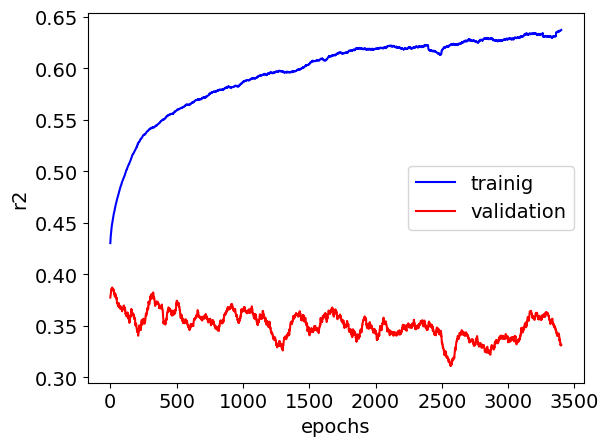

In [16]:
plt.plot(movingAvg(hist.history["coeff_determination"][:3500], 100), 'b-')
plt.plot(movingAvg(hist.history["val_coeff_determination"][:3500], 100), 'r-')
plt.rcParams.update({'font.size':14})
plt.xlabel(r'epochs')
plt.ylabel(r'r2')
plt.legend(['trainig', 'validation'])
#plt.ylim([0.5, 1.])
plt.savefig(f'./ANN_Results/ANN_M2_R2_{model.name}.png')

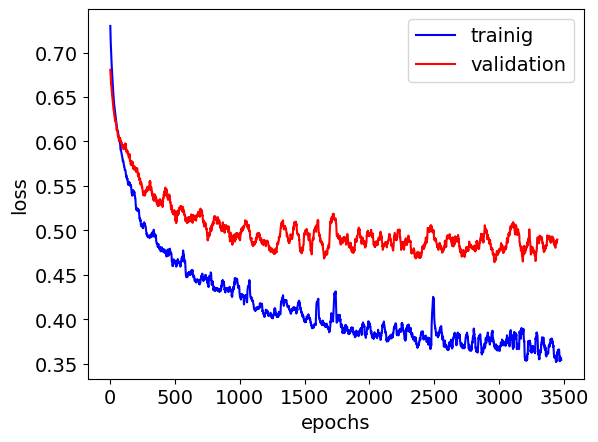

In [17]:
plt.plot(movingAvg(hist.history["loss"][:3500], 20), 'b-')
plt.plot(movingAvg(hist.history["val_loss"][:3500], 50), 'r-')
plt.rcParams.update({'font.size':14})
plt.xlabel(r'epochs')
plt.ylabel(r'loss')
plt.legend(['trainig', 'validation'])
#plt.ylim([0, 0.7])
plt.savefig(f'./ANN_Results/ANN_M2_Loss_{model.name}.png')

In [23]:
model.load_weights('/home/hmarefat/scratch/NECEC2023_local/ANN_checkpoints/ANN_5_60_GUp_LV_weight-3324.h5')

In [24]:
pred = model.predict(dt[:,0:-1])

144180/144180 [==============================] - 111s 768us/step


/tmp/ipykernel_1939567/4286769888.py:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'./ANN_Results/ANN_5_6_GUp_LV_ValueComp_{model.name}.png')
/home/hmarefat/jupEnv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


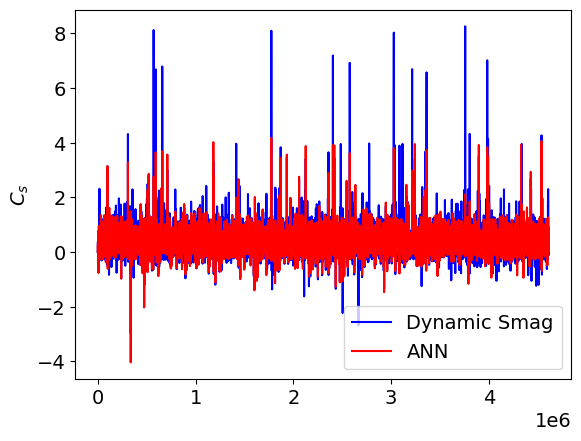

In [20]:
en = 200000
st = 200400
plt.plot((dt[:,-1])*sc[-1]+mn[-1], 'b-')
plt.plot((pred[:])*sc[-1]+mn[-1], 'r-')
plt.rcParams.update({'font.size': 14})
plt.legend(['Dynamic Smag', 'ANN'])
plt.ylabel(r'$C_s$')
plt.savefig(f'./ANN_Results/ANN_M2_ValueComp_{model.name}.png')

In [25]:
def CC(true, pred):
    true = tf.cast(true, tf.float32)
    pred = tf.cast(pred, tf.float32)
    cov = K.sum( (true - K.mean(true)) * (pred - K.mean(pred)) ) / ( len(true) - 1 )
    sigma = lambda y : np.sqrt(K.mean(K.square(y - K.mean(y))))
    return cov / ( sigma(true) * sigma(pred) )

In [26]:
cc = CC(dt[:,-1], pred[:].squeeze())
cc

<tf.Tensor: shape=(), dtype=float32, numpy=0.9561757>

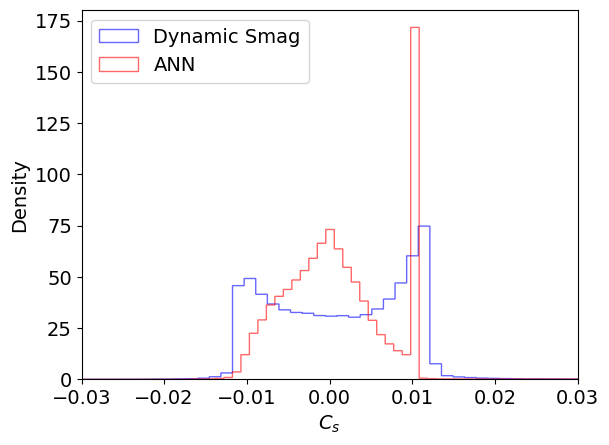

In [23]:
plt.hist((dt[:,-1])*sc[-1]+mn[-1], bins=8000, density=True, alpha=0.6, histtype=u'step', color='blue')
plt.hist((pred[:])*sc[-1]+mn[-1], bins=8000, density=True, alpha=0.6, histtype=u'step', color='red')
plt.rcParams.update({'font.size':14})
plt.legend(['Dynamic Smag', 'ANN'])
#plt.title('Seen Data Comparison')
plt.xlim([-0.03,0.03])
plt.xlabel(r'$C_s$')
plt.ylabel(r'Density')
plt.savefig(f'./ANN_Results/ANN_M2_SeenDensity_{model.name}.png')

In [27]:
pred_U = model.predict(dt_U[:,0:-1])

131073/131073 [==============================] - 101s 774us/step


In [28]:
cc_test = CC(dt_U[:,-1], pred_U[:].squeeze())
cc_test

<tf.Tensor: shape=(), dtype=float32, numpy=0.6974644>

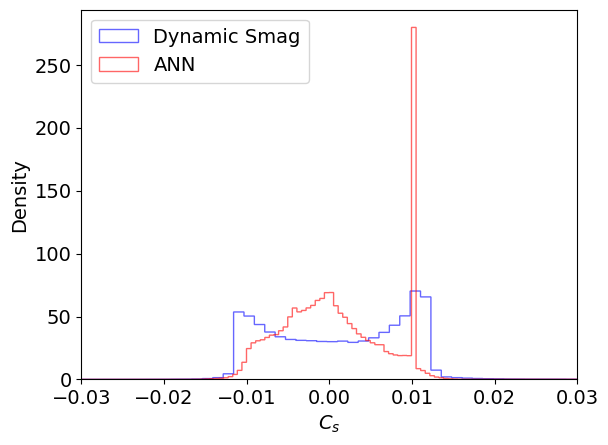

In [25]:
plt.hist((dt_U[:,-1])*sc_U[-1]+mn_U[-1], bins=8000, density=True, alpha=0.6, histtype=u'step', color='blue')
plt.hist((pred_U[:])*sc_U[-1]+mn_U[-1], bins=8000, density=True, alpha=0.6, histtype=u'step', color='red')
plt.legend(['Dynamic Smag', 'ANN'])
#plt.title('UnSeen Data Comparison')
plt.xlim([-0.03,0.03])
plt.xlabel(r'$C_s$')
plt.ylabel(r'Density')
plt.rcParams.update({'font.size':14})
plt.savefig(f'./ANN_Results/ANN_M2_UnSeenDensity_{model.name}.png')

In [ ]:
!nvidia-smi